In [82]:
from dataset.msc_summary_turns import MSC_Turns
from dataset.msc_summary import plot_heatmaps
import json
import pandas as pd
import numpy as np
import itertools
import os
from ast import literal_eval
import matplotlib.pyplot as plt

In [23]:
prepfile = "/Users/FrankVerhoef/Programming/PEX/data/msc/msc_dialogue/preprocessed:trained_base_reweighted_bart:session_4_test.json"
with open(prepfile) as f:
    d = json.loads(f.read())
print(len(d))

501


## Load dataset, stats and evalresults

In [83]:
# Load the MSC_Turns dataset

basedir = "/Users/FrankVerhoef/Programming/PEX/data/msc/msc_personasummary/"
sessions = [1, 2, 3, 4]
subset = 'test'
msc_turns = MSC_Turns(basedir=basedir, sessions=sessions, subset=subset)

In [86]:
# List the available files in the eval_results directory

eval_results_dir = "/Users/FrankVerhoef/Programming/PEX/output/eval_results/"
files = sorted([item.path for item in os.scandir(eval_results_dir) if not item.is_dir()])
files

['/Users/FrankVerhoef/Programming/PEX/output/eval_results/trained2_base_reweighted_bart_20230628_120957_evalresults.txt',
 '/Users/FrankVerhoef/Programming/PEX/output/eval_results/trained2_base_reweighted_bart_20230628_120957_stats.txt',
 '/Users/FrankVerhoef/Programming/PEX/output/eval_results/trained2_base_reweighted_bart_20230628_121242_evalresults.txt',
 '/Users/FrankVerhoef/Programming/PEX/output/eval_results/trained2_base_reweighted_bart_20230628_121242_stats.txt',
 '/Users/FrankVerhoef/Programming/PEX/output/eval_results/trained2_base_reweighted_bart_20230628_121619_evalresults.txt',
 '/Users/FrankVerhoef/Programming/PEX/output/eval_results/trained2_base_reweighted_bart_20230628_121619_stats.txt',
 '/Users/FrankVerhoef/Programming/PEX/output/eval_results/trained2_base_reweighted_bart_20230628_122031_evalresults.txt',
 '/Users/FrankVerhoef/Programming/PEX/output/eval_results/trained2_base_reweighted_bart_20230628_122031_stats.txt',
 '/Users/FrankVerhoef/Programming/PEX/output/eva

In [138]:
# Collect results in dicts
stats_list = []
evalresults_dict = {}
config_list = []

# Load list with ALL trial_names
trial_names = list(set([
    '_'.join((f.split('/')[-1].split('_')[:-1]))
    for f in files
]))

#
# IF NECESSARY: USE ONLY SELF SELECTED FILES
#
trial_names = [
    'trained_nll05_bart_20230715_191928', 
    'trained_nll05_bart_20230716_012913', 
    'trained_nll05_bart_20230715_213740', 
    'trained_rw05_bart_20230715_190156', 
    'trained_rw05_bart_20230715_213435'
]

print("SELECTED TRIALS: ", trial_names)
for trial_name in trial_names:
    with open(f"{eval_results_dir}{trial_name}_stats.txt") as f:
        data = f.read().replace('\n', '')
        stats = json.loads(data.split('}{')[0] + '}')
        stats["trial_name"] = trial_name
        stats["date"] = '_'.join(trial_name.split('_')[-2:])
        config = json.loads('{' + data.split('}{')[1])
        config["trial_name"] = trial_name
        stats_list.append(stats)
        config_list.append(config)

    with open(f"{eval_results_dir}{trial_name}_evalresults.txt") as f:
        data = f.read().replace('\n', '')
        evalresults = json.loads(data.split('}{')[0] + '}')
        evalresults = {literal_eval(k): v for k, v in evalresults.items()}
        evalresults_dict[trial_name] = evalresults
    
# stats_dict[trial_names[0]]
print(len(stats_list), len(evalresults_dict), len(config_list))

SELECTED TRIALS:  ['trained_nll05_bart_20230715_191928', 'trained_nll05_bart_20230716_012913', 'trained_nll05_bart_20230715_213740', 'trained_rw05_bart_20230715_190156', 'trained_rw05_bart_20230715_213435']
5 5 5


In [139]:
# Convert list with stats and configs to dataframe

all_stats_df = pd.DataFrame.from_dict(stats_list)
all_stats_df = all_stats_df.set_index("trial_name")
all_config_df = pd.DataFrame(config_list)
all_config_df = all_config_df.set_index("trial_name")

In [140]:
# Combine stats with config

all_stats_df = all_stats_df.join(all_config_df, validate="1:1")
all_stats_df

,test_loss,test_classification_loss,test_lm_loss,test_acc,test_perplexity,test_token_prediction_acc,eval_acc,eval_f1,eval_precision,eval_recall,...,test_samples,java_home,terpdir,tmpdir,nli_model,speaker_prefixes,nofact_token,add_tokens,len_context,sessions
trial_name,,,,,,,,,,,,,,,,,,,,,
trained_nll05_bart_20230715_191928,1.078764,0.824534,1.078764,0.840600,4.264922,0.660646,0.840508,0.880349,0.907181,0.855058,...,None,/sw/arch/RHEL8/EB_production/2022/software/Jav...,/home/frankv/terp/,/scratch-local/frankv.3076315/,facebook/bart-large-mnli,"[<other>, <self>]",,None,2,"[1, 2, 3, 4]"
trained_nll05_bart_20230716_012913,1.078764,0.824534,1.078764,0.840600,4.264922,0.660646,0.840463,0.880383,0.906668,0.855579,...,None,/sw/arch/RHEL8/EB_production/2022/software/Jav...,/home/frankv/terp/,/scratch-local/frankv.3077532/,facebook/bart-large-mnli,"[<other>, <self>]",,None,2,"[1, 2, 3, 4]"
trained_nll05_bart_20230715_213740,1.078764,0.824534,1.078764,0.840600,4.264922,0.660646,0.844576,0.885516,0.895273,0.875969,...,None,/sw/arch/RHEL8/EB_production/2022/software/Jav...,/home/frankv/terp/,/scratch-local/frankv.3076299/,facebook/bart-large-mnli,"[<other>, <self>]",,None,2,"[1, 2, 3, 4]"
trained_rw05_bart_20230715_190156,1.074466,1.016274,1.074466,0.830325,4.320345,0.660827,0.830227,0.870313,0.914532,0.830174,...,None,/sw/arch/RHEL8/EB_production/2022/software/Jav...,/home/frankv/terp/,/scratch-local/frankv.3076019/,facebook/bart-large-mnli,"[<other>, <self>]",,None,2,"[1, 2, 3, 4]"
trained_rw05_bart_20230715_213435,1.074466,1.016274,1.074466,0.830325,4.320345,0.660827,0.830271,0.870361,0.914478,0.830304,...,None,/sw/arch/RHEL8/EB_production/2022/software/Jav...,/home/frankv/terp/,/scratch-local/frankv.3076173/,facebook/bart-large-mnli,"[<other>, <self>]",,None,2,"[1, 2, 3, 4]"


In [ ]:
# OLD VERSION / OLD FORMAT
# Load the eval_results in dict

output_dir = "/Users/FrankVerhoef/Programming/PEX/output/"
resultsfile = "trained_base_reweighted_bart_evalresults.json"
with open (output_dir + resultsfile) as f:
    eval_results = json.loads(f.read())
eval_results = {literal_eval(k):v for k, v in eval_results.items()}
# list(eval_results.items())[:10]

# Use dict to create dataframe with all eval_results
df = pd.DataFrame.from_dict(eval_results, orient='index')
df.head()

In [241]:
# NEW VERSION / NEW FORMAT
evalresults = evalresults_dict["trained_nll05_bart_20230715_213740"]
print(len(evalresults))

keys = pd.MultiIndex.from_tuples(evalresults.keys())
values = list(evalresults.values())
df = pd.DataFrame.from_records(values, index=keys)
df.head()

22371


convai_id  pred_fact  target_fact  nli_pred  nli_target  \
1 0 0    test_0          1            1  0.997629    0.994330   
    1    test_0          1            1  0.953163    0.984040   
    2    test_0          1            1  0.990445    0.979994   
    3    test_0          1            1  0.894218    0.972481   
    4    test_0          1            1  0.991102    0.977780   

       nli_pred_to_target  nli_target_to_pred  \
1 0 0            0.639634            0.997957   
    1            0.998171            0.998829   
    2            0.998073            0.997944   
    3            0.998901            0.998873   
    4            0.009298            0.646994   

                                            pred_persona  \
1 0 0  I do not own a car. I live in a small town. I ...   
    1               I like going to the gym to work out.   
    2                        I am a computer programmer.   
    3                               I work in marketing.   
    4                         I love meat. I like steak.   

                                          target_persona  numwords_factor  \
1 0 0  I live semi-close towkr. I don't own a car. I ...             0.85   
    1                     I enjoy exercising at the gym.             1.50   
    2                         I'm a computer programmer.             1.25   
    3                            I have a marketing job.             0.80   
    4                             I like grilling steak.             1.50   

       len_p_split  len_t_split      terp  \
1 0 0          3.0          4.0  0.508033   
    1          1.0          1.0  0.635958   
    2          1.0          1.0  0.363080   
    3          1.0          1.0  0.756672   
    4          2.0          1.0  0.492469   

                                              terpscores    terpf1  \
1 0 0  [[1.0, 0.9077003002166748, 1.0], [0.3630801141...  0.857143   
    1                             [[0.7419512867927551]]  0.000000   
    2                             [[0.4538501501083374]]  1.000000   
    3                             [[0.9080064296722412]]  0.000000   
    4        [[0.7892205119132996, 0.35673412680625916]]  0.666667   

       terpprecision  terprecall  
1 0 0            1.0        0.75  
    1            0.0        0.00  
    2            1.0        1.00  
    3            0.0        0.00  
    4            0.5        1.00

In [242]:
###
### Add the item measurements to the dataframe
###

m = msc_turns.measurements()['allitem_measurements']
df_m = pd.DataFrame.from_records(m)
df_m.index = pd.MultiIndex.from_arrays(df_m[['session', 'dialog_id', 'turn_id']].values.T)
df_m = df_m.drop(['convai_id'], axis=1)
df = df.join(df_m, how='inner')

# Add length of prediction
def get_length(sentence):
    l = len(sentence.split())
    return l

df['predictionwords'] = df['pred_persona'].apply(lambda x: get_length(x))
df.columns


Index(['convai_id', 'pred_fact', 'target_fact', 'nli_pred', 'nli_target',
       'nli_pred_to_target', 'nli_target_to_pred', 'pred_persona',
       'target_persona', 'numwords_factor', 'len_p_split', 'len_t_split',
       'terp', 'terpscores', 'terpf1', 'terpprecision', 'terprecall',
       'session', 'dialog_id', 'turn_id', 'inputwords', 'labelwords',
       'predictionwords'],
      dtype='object')

In [ ]:
### OLD VERSION
### Add the item measurements to the dataframe
###

m = msc_turns.measurements()['allitem_measurements']
df_m = pd.DataFrame.from_records(m)
df_m.index = pd.MultiIndex.from_arrays(df_m[['session', 'dialog_id', 'turn_id']].values.T)
df_m = df_m.drop(['convai_id'], axis=1)
df = df.join(df_m, how='inner')

# Add length of prediction
def get_length(sentence):
    l = len(sentence.split())
    return l

df['predictionwords'] = df['pred_persona'].apply(lambda x: get_length(x))
df


In [243]:
###
### Add the input sentence from dataset to the dataframe
###

df['history'] = [msc_turns[i][0].replace('\n', '<sep>') for i in range(len(msc_turns))]
df

convai_id  pred_fact  target_fact  nli_pred  nli_target  \
1 0   0      test_0          1            1  0.997629    0.994330   
      1      test_0          1            1  0.953163    0.984040   
      2      test_0          1            1  0.990445    0.979994   
      3      test_0          1            1  0.894218    0.972481   
      4      test_0          1            1  0.991102    0.977780   
...             ...        ...          ...       ...         ...   
4 500 6   test_1014          1            1  0.990898    0.993115   
      7   test_1014          0            0  0.002679    0.002679   
      8   test_1014          0            0  0.001715    0.001715   
      9   test_1014          1            1  0.951873    0.950607   
      10  test_1014          0            0  0.000277    0.000277   

          nli_pred_to_target  nli_target_to_pred  \
1 0   0             0.639634            0.997957   
      1             0.998171            0.998829   
      2             0.998073            0.997944   
      3             0.998901            0.998873   
      4             0.009298            0.646994   
...                      ...                 ...   
4 500 6             0.998885            0.983701   
      7             0.279058            0.279058   
      8             0.279058            0.279058   
      9             0.000857            0.990895   
      10            0.279058            0.279058   

                                               pred_persona  \
1 0   0   I do not own a car. I live in a small town. I ...   
      1                I like going to the gym to work out.   
      2                         I am a computer programmer.   
      3                                I work in marketing.   
      4                          I love meat. I like steak.   
...                                                     ...   
4 500 6                         I have been to Denver once.   
      7                                                       
      8                                                       
      9                                    I have a family.   
      10                                                      

                                             target_persona  numwords_factor  \
1 0   0   I live semi-close towkr. I don't own a car. I ...         0.850000   
      1                      I enjoy exercising at the gym.         1.500000   
      2                          I'm a computer programmer.         1.250000   
      3                             I have a marketing job.         0.800000   
      4                              I like grilling steak.         1.500000   
...                                                     ...              ...   
4 500 6                              I have visited Denver.         1.500000   
      7                                                                  NaN   
      8                                                                  NaN   
      9              I will be doing a hike with my family.         0.444444   
      10                                                                 NaN   

          ...    terpf1  terpprecision  terprecall session  dialog_id  \
1 0   0   ...  0.857143            1.0        0.75       1          0   
      1   ...  0.000000            0.0        0.00       1          0   
      2   ...  1.000000            1.0        1.00       1          0   
      3   ...  0.000000            0.0        0.00       1          0   
      4   ...  0.666667            0.5        1.00       1          0   
...       ...       ...            ...         ...     ...        ...   
4 500 6   ...  1.000000            1.0        1.00       4        500   
      7   ...       NaN            NaN         NaN       4        500   
      8   ...       NaN            NaN         NaN       4        500   
      9   ...  0.000000            0.0        0.00       4        500   
      10  ...       NaN            

## Analysis of persona extraction

### Length

In [244]:
selection = (df['target_persona'] != '') & (df['session'] != 1)
print(df[selection].groupby(['session'])['labelwords'].mean())
print(df[selection]['labelwords'].mean())

selection = (df['pred_persona'] != '') &(df['session'] != 1)
print(df[selection].groupby(['session'])['predictionwords'].mean())
print(df[selection]['predictionwords'].mean())

session
2     9.747765
3    10.315015
4    10.328499
Name: labelwords, dtype: float64
10.133412800293417
session
2    6.965855
3    6.804094
4    6.922586
Name: predictionwords, dtype: float64
6.89858264700249


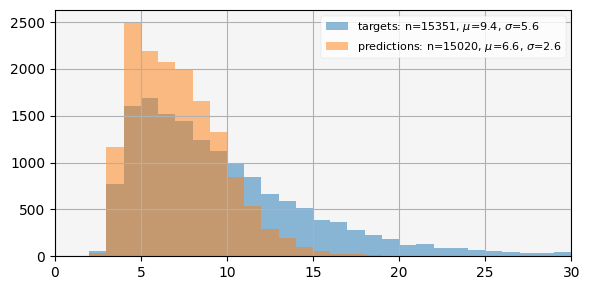

In [259]:
fig, ax=plt.subplots(figsize=(6,3))
bins=np.linspace(0, 30, 31)

selectors = ['target_fact', 'pred_fact']
columns = ['labelwords', 'predictionwords']
labels = ['targets', 'predictions']

with plt.style.context('seaborn-v0_8-paper'):
    for selector, col, label in zip(selectors, columns, labels):
        data = df[df[selector] == 1][col]
        df[df[selector] == 1].hist(column=col, bins=bins, ax=ax, alpha=0.5, label=f"{label}: n={data.count()}, $\mu$={data.mean():.1f}, $\sigma$={data.std():.1f}")

    ax.set_facecolor('whitesmoke')
    ax.set_title('')
    ax.set_xlim(0,30)
    ax.legend()
    fig.tight_layout()

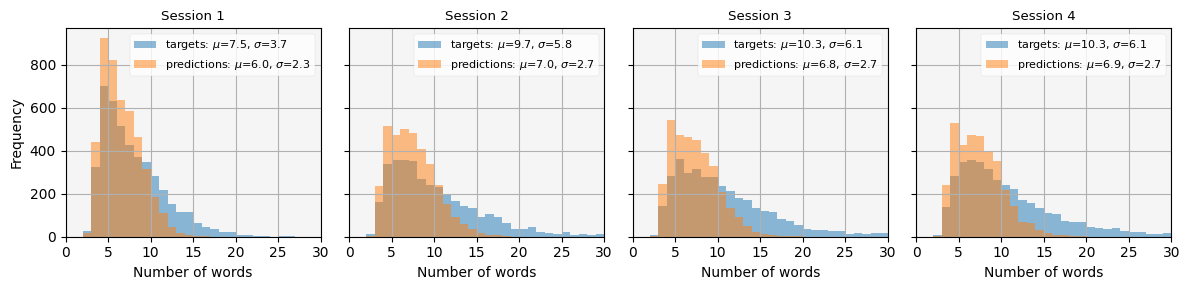

In [264]:
fig, axs=plt.subplots(ncols=4, figsize=(12,3), sharey=True)
bins=np.linspace(0, 30, 31)

selectors = ['target_fact', 'pred_fact']
columns = ['labelwords', 'predictionwords']
labels = ['targets', 'predictions']

with plt.style.context('seaborn-v0_8-paper'):
    for session, ax in zip([1, 2, 3, 4], axs):
        selection = df['session'] == session
        for selector, col, label in zip(selectors, columns, labels):
            data = df[selection & (df[selector] == 1)][col]
            df[selection & (df[selector] == 1)].hist(column=col, bins=bins, ax=ax, alpha=0.5, label=f"{label}: $\mu$={data.mean():.1f}, $\sigma$={data.std():.1f}")

        ax.set_facecolor('whitesmoke')
        ax.set_title(f"Session {session}")
        ax.set_xlim(0,30)
        ax.set_xlabel("Number of words")
        ax.legend()
        if session == 1:
            ax.set_ylabel("Frequency")

    fig.tight_layout()

### Classification

In [ ]:
sessions = df['session'].unique()
fig, ax = plt.subplots(ncols=len(sessions), figsize=(12,4), sharey=True, sharex=True)


selection = {}
selection["TP"] = (df['target_fact'] == 1) & (df['pred_fact'] == 1)
selection["TN"] = (df['target_fact'] == 0) & (df['pred_fact'] == 0)
selection["FP"] = (df['target_fact'] == 0) & (df['pred_fact'] == 1)
selection["FN"] = (df['target_fact'] == 1) & (df['pred_fact'] == 0)
col = {
    "TP": 'tab:blue',
    "TN": 'tab:cyan',
    "FP": 'tab:orange',
    "FN": 'tab:red'
}
for i, session in enumerate(sessions):
    selected_session = df['session'] == session
    total = len(df[selected_session])
    for s in selection.keys():
        count = len(df[selected_session & selection[s]])
        label = f"{s}: {count/total:.0%}"
        df[selected_session & selection[s]].plot.scatter('inputwords', 'labelwords', c=col[s], alpha=0.5, label=label, ax=ax[i])
    ax[i].set_title(f"session {session}")

fig.suptitle("Accuracy of predicted facts, per session")

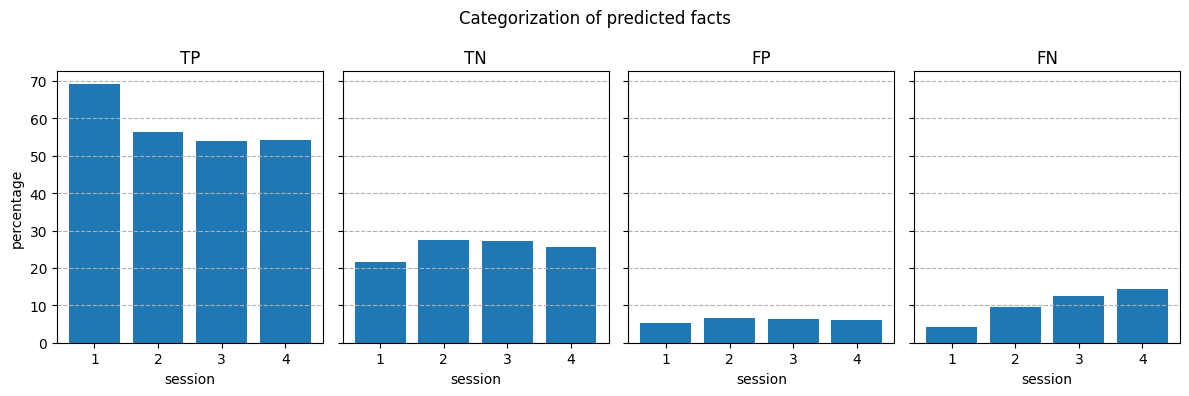

In [217]:
sessions = df['session'].unique()

selection = {}
selection["TP"] = (df['target_fact'] == 1) & (df['pred_fact'] == 1)
selection["TN"] = (df['target_fact'] == 0) & (df['pred_fact'] == 0)
selection["FP"] = (df['target_fact'] == 0) & (df['pred_fact'] == 1)
selection["FN"] = (df['target_fact'] == 1) & (df['pred_fact'] == 0)
col = {
    "TP": 'tab:blue',
    "TN": 'tab:cyan',
    "FP": 'tab:orange',
    "FN": 'tab:red'
}
fig, ax = plt.subplots(ncols=len(selection.keys()), figsize=(12,4), sharey=True, sharex=True)

session_total = df.groupby(['session'])['turn_id'].count().values

for i, s in enumerate(selection.keys()):
    category_count = df[selection[s]].groupby(['session'])['turn_id'].count()
    perc = category_count / session_total * 100
    ax[i].bar(x=sessions, height=perc)
    ax[i].grid(which='major', axis='y', linestyle='--')
    ax[i].set_title(s)
    ax[i].set_xticks(sessions)
    ax[i].set_xlabel("session")
    if i == 0:
        ax[i].set_ylabel("percentage")

fig.suptitle("Categorization of predicted facts")
fig.tight_layout()

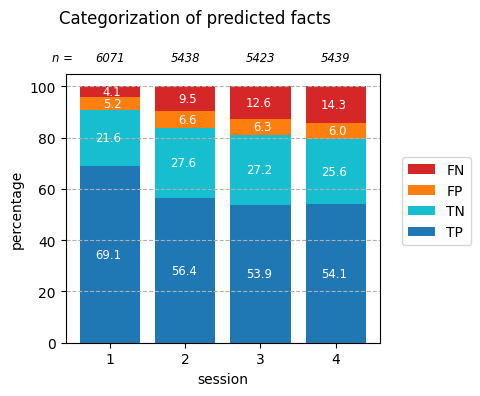

In [218]:
sessions = df['session'].unique()

selection = {}
selection["TP"] = (df['target_fact'] == 1) & (df['pred_fact'] == 1)
selection["TN"] = (df['target_fact'] == 0) & (df['pred_fact'] == 0)
selection["FP"] = (df['target_fact'] == 0) & (df['pred_fact'] == 1)
selection["FN"] = (df['target_fact'] == 1) & (df['pred_fact'] == 0)
col = {
    "TP": 'tab:blue',
    "TN": 'tab:cyan',
    "FP": 'tab:orange',
    "FN": 'tab:red'
}
fig, ax = plt.subplots(figsize=(4,4))

session_total = df.groupby(['session'])['turn_id'].count().values
bottom = np.zeros(len(selection.keys()))

for s in selection.keys():
    category_count = df[selection[s]].groupby(['session'])['turn_id'].count().values
    perc = category_count / session_total * 100
    ax.bar(x=sessions, height=perc, bottom=bottom, color=col[s], label=s)
    for session, b, p in zip(sessions, bottom, perc):
        ax.text(session + 0.15, b + p/2, f"{p:.1f}", horizontalalignment='right', verticalalignment='center', fontsize='small', c='w')
    bottom += perc

ax.text(0.5, 110, "n =", horizontalalignment='right', fontsize='small', fontstyle='italic')
for session, t in zip(sessions, session_total):
    ax.text(session, 110, t, horizontalalignment='center', fontsize='small', fontstyle='italic')
ax.grid(which='major', axis='y', linestyle='--')
ax.set_xticks(sessions)
ax.set_xlabel("session")
ax.set_ylabel("percentage")

fig.suptitle("Categorization of predicted facts")
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5), reverse=True)
fig.tight_layout()

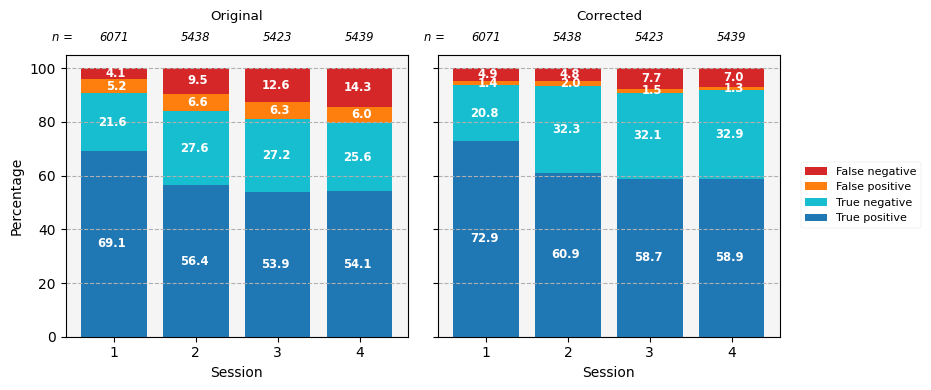

In [219]:
sessions = df['session'].unique()

# Below are the findings from review of a sample of 344 predictions. 
# These were checked to confirm if the annotated facts were indeed correct, but also if dialogues where no fact was annotated was correct
# This leads to a correction of the TP, TN, FP, FN categories.capitalize
# The array below is ordered per session, original label (TP, TN, FP, FN), revised label (TP, TN, FP, FN)
# For example, for session 3, there are 16 FP's that are in fact TP, and 5 FP's are correctly labeled as FP.
review = np.array([
    [[27, 0, 0, 0],
     [0, 19, 0, 1],
     [8, 0, 3, 0],
     [0, 1, 0, 13]],
    [[15, 0, 0, 0], 
     [0, 27, 0, 1],
     [20, 0, 9, 0],
     [0, 12, 0, 8]],
    [[24, 0, 0, 0],
     [0, 17, 0, 0],
     [16, 0, 5, 0],
     [0, 7, 0, 11]],
    [[24, 0, 0, 0],
     [0, 23, 0, 2],
     [15, 0, 4, 0],
     [0, 21, 0, 11]],
])
correction_matrix = np.array([
    review[s] / review[s].sum(axis=1).reshape(-1, 1)
    for s in range(4)
])

selection = {}
selection["True positive"] = (df['target_fact'] == 1) & (df['pred_fact'] == 1)
selection["True negative"] = (df['target_fact'] == 0) & (df['pred_fact'] == 0)
selection["False positive"] = (df['target_fact'] == 0) & (df['pred_fact'] == 1)
selection["False negative"] = (df['target_fact'] == 1) & (df['pred_fact'] == 0)
col = {
    "True positive": 'tab:blue',
    "True negative": 'tab:cyan',
    "False positive": 'tab:orange',
    "False negative": 'tab:red'
}


session_total = df.groupby(['session'])['turn_id'].count().values
original_counts = np.array([
    df[selection[s]].groupby(['session'])['turn_id'].count().values
    for s in selection.keys()
])
corrected_counts = np.array([
    original_counts[:,s] @ correction_matrix[s]
    for s in range(4)
]).T

chart_data = np.array([original_counts, corrected_counts])
titles = ["Original", "Corrected"]

fig, axs = plt.subplots(ncols=2, figsize=(8,4), sharey=True)
with plt.style.context('seaborn-v0_8-paper'):
    for dataset, ax in zip(range(2), axs):

        bottom = np.zeros(len(selection.keys()))
        for i, s in enumerate(selection.keys()):
            perc = chart_data[dataset][i] / session_total * 100
            ax.bar(x=sessions, height=perc, bottom=bottom, color=col[s], label=s)
            for session, b, p in zip(sessions, bottom, perc):
                ax.text(session + 0.15, b + p/2, f"{p:.1f}", horizontalalignment='right', verticalalignment='center', fontsize='small', fontweight='bold', c='w')
            bottom += perc

        ax.set_facecolor('whitesmoke')
        ax.set_title(titles[dataset], pad=25)
        ax.text(0.5, 110, "n =", horizontalalignment='right', fontsize='small', fontstyle='italic')
        for session, t in zip(sessions, session_total):
            ax.text(session, 110, t, horizontalalignment='center', fontsize='small', fontstyle='italic')
        ax.grid(which='major', axis='y', linestyle='--')
        ax.set_xticks(sessions)
        ax.set_xlabel("Session")
        if dataset == 0:
            ax.set_ylabel("Percentage")

    # fig.suptitle("Categorization of predicted facts")
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    fig.legend(by_label.values(), by_label.keys(), loc='center left', bbox_to_anchor=(1, 0.5), reverse=True)
    # fig.legend(loc='center left', bbox_to_anchor=(1, 0.5), reverse=True)
    fig.tight_layout()

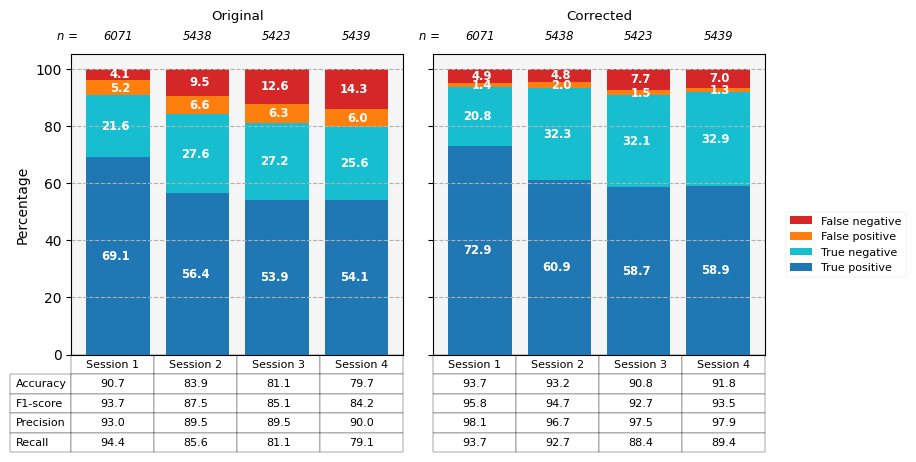

In [220]:
sessions = df['session'].unique()

# Below are the findings from review of a sample of 344 predictions. 
# These were checked to confirm if the annotated facts were indeed correct, but also if dialogues where no fact was annotated was correct
# This leads to a correction of the TP, TN, FP, FN categories.capitalize
# The array below is ordered per session, original label (TP, TN, FP, FN), revised label (TP, TN, FP, FN)
# For example, for session 3, there are 16 FP's that are in fact TP, and 5 FP's are correctly labeled as FP.
review = np.array([
    [[27, 0, 0, 0],
     [0, 19, 0, 1],
     [8, 0, 3, 0],
     [0, 1, 0, 13]],
    [[15, 0, 0, 0], 
     [0, 27, 0, 1],
     [20, 0, 9, 0],
     [0, 12, 0, 8]],
    [[24, 0, 0, 0],
     [0, 17, 0, 0],
     [16, 0, 5, 0],
     [0, 7, 0, 11]],
    [[24, 0, 0, 0],
     [0, 23, 0, 2],
     [15, 0, 4, 0],
     [0, 21, 0, 11]],
])
correction_matrix = np.array([
    review[s] / review[s].sum(axis=1).reshape(-1, 1)
    for s in range(4)
])

selection = {}
selection["True positive"] = (df['target_fact'] == 1) & (df['pred_fact'] == 1)
selection["True negative"] = (df['target_fact'] == 0) & (df['pred_fact'] == 0)
selection["False positive"] = (df['target_fact'] == 0) & (df['pred_fact'] == 1)
selection["False negative"] = (df['target_fact'] == 1) & (df['pred_fact'] == 0)
col = {
    "True positive": 'tab:blue',
    "True negative": 'tab:cyan',
    "False positive": 'tab:orange',
    "False negative": 'tab:red'
}


session_total = df.groupby(['session'])['turn_id'].count().values
original_counts = np.array([
    df[selection[s]].groupby(['session'])['turn_id'].count().values
    for s in selection.keys()
])
corrected_counts = np.array([
    original_counts[:,s] @ correction_matrix[s]
    for s in range(4)
]).T

chart_data = np.array([original_counts, corrected_counts])
titles = ["Original", "Corrected"]

fig, axs = plt.subplots(ncols=2, figsize=(8,5), sharey=True)
with plt.style.context('seaborn-v0_8-paper'):
    for dataset, ax in zip(range(2), axs):

        bottom = np.zeros(len(selection.keys()))
        for i, s in enumerate(selection.keys()):
            perc = chart_data[dataset][i] / session_total * 100
            ax.bar(x=sessions, height=perc, bottom=bottom, color=col[s], label=s)
            for session, b, p in zip(sessions, bottom, perc):
                ax.text(session + 0.15, b + p/2, f"{p:.1f}", horizontalalignment='right', verticalalignment='center', fontsize='small', fontweight='bold', c='w')
            bottom += perc


        # Plot a table with Accuracy, F1, Precision, Recall
        acc = (chart_data[dataset][0] + chart_data[dataset][1]) / sum(chart_data[dataset])
        prec = chart_data[dataset][0] / (chart_data[dataset][0] + chart_data[dataset][2])
        rec = chart_data[dataset][0] / (chart_data[dataset][0] + chart_data[dataset][3])
        f1 = [(2 * p * r) / (p + r) if (p + r) != 0 else 0 for p, r in zip(prec, rec)]
        ax_table = ax.table(
            cellText=np.round(np.array([acc, f1, prec, rec]) * 100, 1),
            colLabels=[f"Session {s}" for s in sessions],
            rowLabels=["Accuracy", "F1-score", "Precision", "Recall"] if dataset == 0 else None,
            cellLoc='center',
            loc='bottom',
        )
        ax_table.scale(1, 1.5)
        # ax_table.auto_set_font_size(False)
        # ax_table.set_fontsize(10)

        ax.set_facecolor('whitesmoke')
        ax.set_title(titles[dataset], pad=25)
        ax.text(0.5, 110, "n =", horizontalalignment='right', fontsize='small', fontstyle='italic')
        for session, t in zip(sessions, session_total):
            ax.text(session, 110, t, horizontalalignment='center', fontsize='small', fontstyle='italic')
        ax.grid(which='major', axis='y', linestyle='--')
        # ax.set_xticks(sessions)
        # ax.set_xlabel("Session")
        ax.set_xticks([])
        if dataset == 0:
            ax.set_ylabel("Percentage")

    # fig.suptitle("Categorization of predicted facts")
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    fig.legend(by_label.values(), by_label.keys(), loc='center left', bbox_to_anchor=(1, 0.5), reverse=True)
    # fig.legend(loc='center left', bbox_to_anchor=(1, 0.5), reverse=True)
    fig.tight_layout()

Session total:  [82  2  0  0]
Session total:  [2056  216  134  118]
Session total:  [3683  810  595  520]
Session total:  [ 246 1204 1109  999]
Session total:  [   4 1190 1171 1139]
Session total:  [   0  871 1009  940]
Session total:  [   0  838 1025 1161]
Session total:  [  0 231 290 416]
Session total:  [  0  76  90 146]


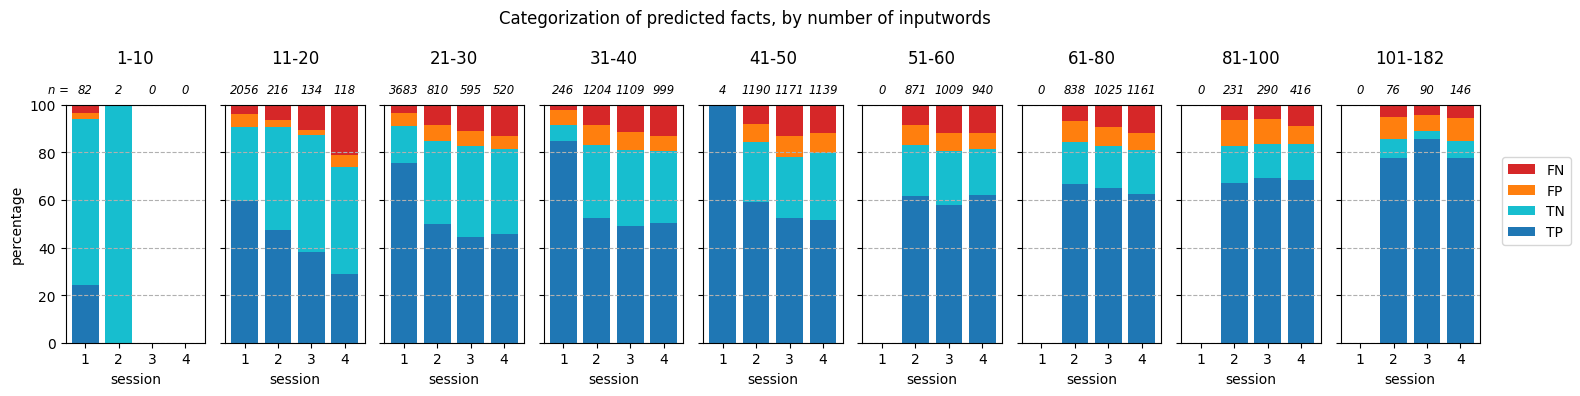

In [197]:
sessions = df['session'].unique()

selection = {}
selection["TP"] = (df['target_fact'] == 1) & (df['pred_fact'] == 1)
selection["TN"] = (df['target_fact'] == 0) & (df['pred_fact'] == 0)
selection["FP"] = (df['target_fact'] == 0) & (df['pred_fact'] == 1)
selection["FN"] = (df['target_fact'] == 1) & (df['pred_fact'] == 0)
col = {
    "TP": 'tab:blue',
    "TN": 'tab:cyan',
    "FP": 'tab:orange',
    "FN": 'tab:red'
}
max_inputwords = df['inputwords'].max()
bin_boundaries = [0, 10, 20, 30, 40, 50, 60, 80, 100, max_inputwords]
# bin_boundaries = [0, 20, 40, 200]
bins = [(lower + 1, upper) for lower, upper in zip(bin_boundaries[:-1], bin_boundaries[1:])]

fig, ax = plt.subplots(ncols=len(bins), figsize=(15, 4), sharey=True)


for i, (lower, upper) in enumerate(bins):
    selected_bin = (df['inputwords'] >= lower) & (df['inputwords'] <= upper)
    session_total = np.array([len(df[selected_bin & (df['session'] == session)]) for session in sessions])
    print("Session total: ", session_total)
    bottom = np.zeros(len(selection.keys()))

    for s in selection.keys():
        category_count = np.array([len(df[selected_bin & selection[s] & (df['session'] == session)]) for session in sessions])
        # print("Category count: ", category_count)
        perc = category_count / np.maximum(session_total, np.ones_like(session_total)) * 100
        ax[i].bar(x=sessions, height=perc, bottom=bottom, color=col[s], label=s)
        bottom += perc

    ax[i].grid(which='major', axis='y', linestyle='--')
    ax[i].set_title(f"{lower}-{upper}", pad=30)
    for s, t in enumerate(session_total):
        ax[i].text(s + 1, 105, session_total[s], horizontalalignment='center', fontsize='small', fontstyle='italic')
    ax[i].set_xticks(sessions)
    ax[i].set_xlabel("session")
    if i == 0:
        ax[i].text(0.5, 105, "n =", horizontalalignment='right', fontsize='small', fontstyle='italic')
        ax[i].set_ylabel("percentage")

fig.suptitle("Categorization of predicted facts, by number of inputwords")
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
fig.legend(by_label.values(), by_label.keys(), loc='center left', bbox_to_anchor=(1, 0.5), reverse=True)
fig.tight_layout()

### TERp

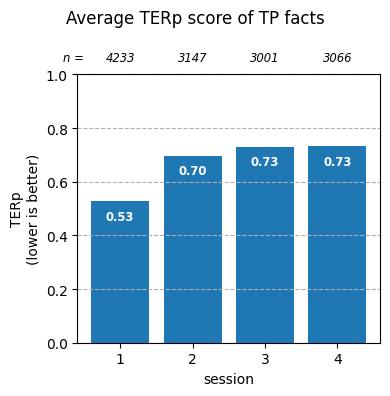

In [198]:
sessions = df['session'].unique()

selection = {}
selection["TP"] = (df['target_fact'] == 1) & (df['pred_fact'] == 1)
selection["TN"] = (df['target_fact'] == 0) & (df['pred_fact'] == 0)
selection["FP"] = (df['target_fact'] == 0) & (df['pred_fact'] == 1)
selection["FN"] = (df['target_fact'] == 1) & (df['pred_fact'] == 0)

fig, ax = plt.subplots(figsize=(4,4))

terp_mean = df[selection["TP"]].groupby(['session'])['terp'].mean().values
terp_count =  df[selection["TP"]].groupby(['session'])['terp'].count().values

ax.bar(x=sessions, height=terp_mean)
for session, m in zip(sessions, terp_mean):
    ax.text(session, m - 0.07, f"{m:.2f}", horizontalalignment='center', fontweight='bold', fontsize='small', c='w')

ax.text(0.5, 1.05, "n =", horizontalalignment='right', fontsize='small', fontstyle='italic')
for session, t in zip(sessions, terp_count):
    ax.text(session, 1.05, t, horizontalalignment='center', fontsize='small', fontstyle='italic')
ax.grid(which='major', axis='y', linestyle='--')
ax.set_xticks(sessions)
ax.set_xlabel("session")
ax.set_ylim(0,1)
ax.set_ylabel("TERp\n(lower is better)")

fig.suptitle("Average TERp score of TP facts")
fig.tight_layout()

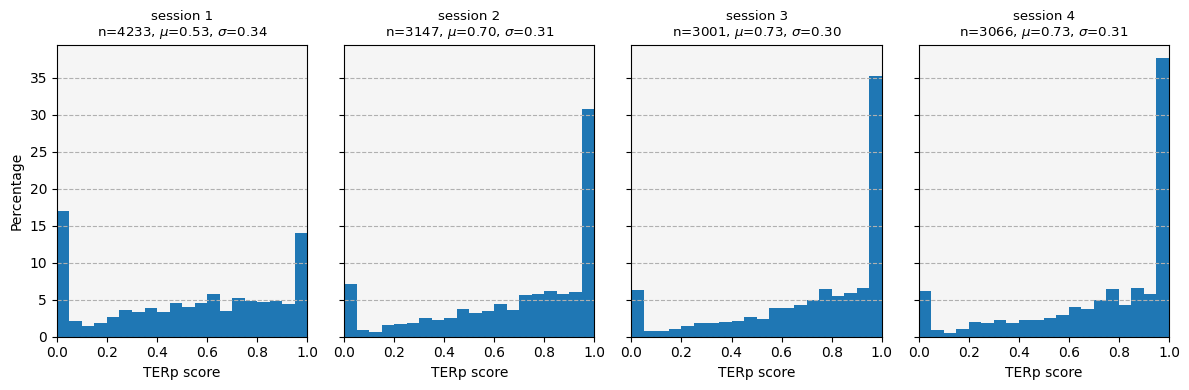

In [200]:
sessions = df['session'].unique()

selection = {}
selection["TP"] = (df['target_fact'] == 1) & (df['pred_fact'] == 1)
selection["TN"] = (df['target_fact'] == 0) & (df['pred_fact'] == 0)
selection["FP"] = (df['target_fact'] == 0) & (df['pred_fact'] == 1)
selection["FN"] = (df['target_fact'] == 1) & (df['pred_fact'] == 0)

fig, axs = plt.subplots(ncols=len(sessions), figsize=(12,4), sharey=True)

with plt.style.context('seaborn-v0_8-paper'):
    for session, ax in zip(sessions, axs):

        df_subset = df[selection["TP"] & (df['session'] == session)]['terp']
        terp_mean = df_subset.mean()
        terp_std = df_subset.std()
        terp_count =  df_subset.count()

        ax.hist(df_subset, bins=20, range=(0,1), density=True)

        ax.set_facecolor('whitesmoke')
        ax.set_title(f"session {session}\nn={terp_count}, " + r"$\mu$" + f"={terp_mean:.2f}, " + r"$\sigma$" + f"={terp_std:.2f}")
        ax.grid(which='major', axis='y', linestyle='--')
        ax.set_xlim(0,1)
        ax.set_xlabel("TERp score")
        if session == 1:
            ax.set_yticks(np.array(range(11)))
            ax.set_yticklabels(np.array(range(11))*5)
            ax.set_ylabel("Percentage")

    # fig.suptitle("Distribution of TERp scores of TP facts")
    fig.tight_layout()

In [201]:
df.sort_values(by=['terp'])[['target_persona', 'pred_persona', 'terp']].head(10)

target_persona  \
2 394 4            I used to have a Ford Edge.   
1 231 4             I have a dog named drunky.   
  469 1                       I enjoy running.   
3 172 5                       I have two cats.   
      9               I used to have pet rats.   
  173 8  I am going on a Mediterranean cruise.   
  175 6                        I hate spiders.   
  179 8  I would like to see the Eiffel Tower.   
  183 3                I have 8 grandchildren.   
  184 0                       I have children.   

                                  pred_persona  terp  
2 394 4            I used to have a Ford Edge.   0.0  
1 231 4             I have a dog named drunky.   0.0  
  469 1                        I love running.   0.0  
3 172 5                       I have two cats.   0.0  
      9               I used to have pet rats.   0.0  
  173 8  I am going on a Mediterranean cruise.   0.0  
  175 6                        I hate spiders.   0.0  
  179 8  I would like to see the Eiffel Tower.   0.0  
  183 3                I have 8 grandchildren.   0.0  
  184 0                           I have kids.   0.0

In [202]:
df.sort_values(by=['terp'], ascending=False)[['target_persona', 'pred_persona', 'terp']].head(10)

target_persona  \
3 101 3   I go running regularly in non-urban areas. I p...   
  80  4   I once got caught in a riptide during a visit ...   
1 426 7   I have not decided whether I will be attending...   
4 165 10                          I worry about financials.   
      9   i show my kids different activities. I like to...   
      8   i always wanted a big family. i am scared to a...   
1 428 1   My favorite band is black sabbath. I'm a worka...   
      9                                       I have a job.   
  429 0                                       I'm schmitty.   
3 82  2                I run in marathons. I enjoy running.   

                                               pred_persona  terp  
3 101 3                            I see a lot of wildlife.   1.0  
  80  4                       I am nervous about the ocean.   1.0  
1 426 7                                   I am moving soon.   1.0  
4 165 10  I don't want my kids to feel forced into somet...   1.0  
      9                                      I have 2 kids.   1.0  
      8       I am thinking about having a lot of children.   1.0  
1 428 1           I am a workaholic. I miss concerts often.   1.0  
      9                     I like to explore other genres.   1.0  
  429 0                                   My name is Kitty.   1.0  
3 82  2                       I am training for a marathon.   1.0

In [39]:
selection = (df['terp'] >= 0.95) & (df['session'] != 1) #& (df['terp'] <= 0.75) 
table_df = df[selection][['history', 'target_persona', 'pred_persona', 'terp']].sample(10).sort_values(by=['terp'])
table_df.set_index(['history'], inplace=True)  #['target_persona', 'pred_persona'],inplace=True)
s = table_df.style.format({
    'terp': '{:.2f}', 
})
print(s.to_latex(hrules=True, clines="all;data").replace('<sep>', '\\texttt{<sep>}'))
s

\begin{tabular}{lllr}
\toprule
 & target_persona & pred_persona & terp \\
history &  &  &  \\
\midrule
I know you're right, but sometimes those vet bills can be outrageous.  I think I'll give it a couple of more days to see if she gets better on her own.  You been out on any runs lately? \texttt{<sep>}I totally agree… thos enormous bills are what keep me from getting another pet. Well, I hope she bounces back soon :) And yes, I just came back from a run half hour ago. Java tagged along happily which is why he was ready to eat and snooze soon as we got back lol & Java runs with me. I go for runs. & I have a pet named Java. & 1.00 \\
\cline{1-4}
Oh ok! So what did you mean when you said it has to do with knowing your mom?\texttt{<sep>}Everyone in town knows who my mom is. Not sure if it is from working with the police or from a commercial she did. But they all ask about her. & People ask about my mom. Everyone in town knows who my mom is. & I have a mom. & 1.00 \\
\cline{1-4}
There's gre

,target_persona,pred_persona,terp
history,,,
"I know you're right, but sometimes those vet bills can be outrageous. I think I'll give it a couple of more days to see if she gets better on her own. You been out on any runs lately? I totally agree… thos enormous bills are what keep me from getting another pet. Well, I hope she bounces back soon :) And yes, I just came back from a run half hour ago. Java tagged along happily which is why he was ready to eat and snooze soon as we got back lol",Java runs with me. I go for runs.,I have a pet named Java.,1.00
Oh ok! So what did you mean when you said it has to do with knowing your mom?Everyone in town knows who my mom is. Not sure if it is from working with the police or from a commercial she did. But they all ask about her.,People ask about my mom. Everyone in town knows who my mom is.,I have a mom.,1.00
"There's great shopping there. Some places are expensive, but you can find some great bargains. What does your boyfriend like to do? Shopping?He likes to drink, so hoping I can find good bars or clubs to enjoy the night. We also look forward to have some refreshing beers by the beach. What's the most popular beach there?",I plan to visit the beach. I find beer refreshing.,I have a boyfriend.,1.00
"It is tough financially, but it's even tougher regarding time. It seems like I'm either working 80 hours a week or 10 hours a week. It is impossible to budget right now, though.I can imagine. Your starting to scare me off from the dream of having my own business. Well, like I said, if you need any help just let me know. I have the time to do whatever is necessary to help you.",I dream to own my own business.,I have the time to help you.,1.00
I think I prefer chicken to anything as it is so versatile. What about you?I like chicken but i love lamb and yes i'm in love with lamb chops. I can eat it every day i guess. I don't understand bacon though.,I love lamb and lamb chops.,I don't understand bacon. I like chicken.,1.00
Did you finish furnishing your house?Not yet. I have decided to redo some old furniture myself. It is time consuming but the results in the end are worth it.,I am redoing some old furniture in my house.,I have a house.,1.00
Cool! Feel free to bring along the kids; maybe do some light biking as well?that would be great. The kids have been on their phones a lot lately and I need to make them be at least somewhat active.,My kids are on their phones a lot. I would like to get my kids more active. I have kids.,I have kids.,1.00
"I don't, but I could ask around and see if someone is open for that Friday night.Okay, I guess it's better if you do that. I think my boss would be pretty angry if I try to get time off again.",I have tried to get time off from work recently. I'm afraid of making my boss mad.,I work at a restaurant.,1.00
"There's a stuffed peppers recipe I have that's amazing. I've never tried it using a meat substitute, but I bet that you could use the Impossible Burger as the filling.Maybe you can try stuffed peppers with chicken? I actually miss chicken haha","I like chicken, but don't eat it anymore.",I miss chicken.,1.00


In [40]:
selection = (df['terp'] >= 0) & (df['terp'] <= 0.75) & (df['session'] == 1)
good_terp = df[selection]['terp'].count()
total = df[(df['terp'] >= 0)  & (df['session'] == 1)]['terp'].count()
print(good_terp, total, good_terp/total)


2517 4194 0.600143061516452


### NLI-score

In [221]:
print(df[(df['pred_fact'] == 1) & (df['target_fact'] == 1) ]['nli_pred_to_target'].mean())
print(df[df['pred_fact'] == 1]['nli_pred'].mean())

0.32048493836661696
0.7784931443086519


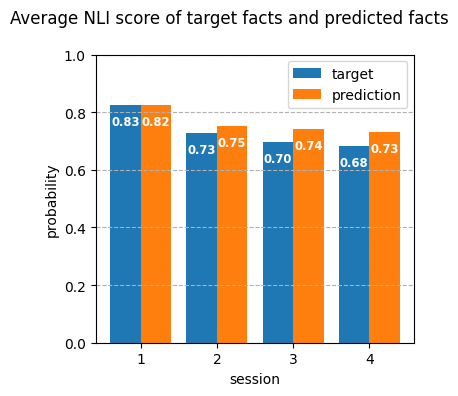

In [199]:
sessions = df['session'].unique()

selection = {}
selection["TP"] = (df['target_fact'] == 1) & (df['pred_fact'] == 1)
selection["TN"] = (df['target_fact'] == 0) & (df['pred_fact'] == 0)
selection["FP"] = (df['target_fact'] == 0) & (df['pred_fact'] == 1)
selection["FN"] = (df['target_fact'] == 1) & (df['pred_fact'] == 0)

fig, ax = plt.subplots(figsize=(4,4))

nli_target_mean = df[df['target_fact'] == 1].groupby(['session'])['nli_target'].mean().values
nli_pred_mean = df[df['pred_fact'] == 1].groupby(['session'])['nli_pred'].mean().values

ax.bar(x=sessions - 0.2, height=nli_target_mean, width=0.4, label="target")
ax.bar(x=sessions + 0.2, height=nli_pred_mean, width=0.4, label="prediction")
for session, m in zip(sessions, nli_target_mean):
    ax.text(session - 0.2, m - 0.07, f"{m:.2f}", horizontalalignment='center', fontweight='bold', fontsize='small', c='w')
for session, m in zip(sessions, nli_pred_mean):
    ax.text(session + 0.2, m - 0.07, f"{m:.2f}", horizontalalignment='center', fontweight='bold', fontsize='small', c='w')

ax.legend()
ax.grid(which='major', axis='y', linestyle='--')
ax.set_xticks(sessions)
ax.set_xlabel("session")
ax.set_ylim(0,1)
ax.set_ylabel("probability")

fig.suptitle("Average NLI score of target facts and predicted facts")
fig.tight_layout()

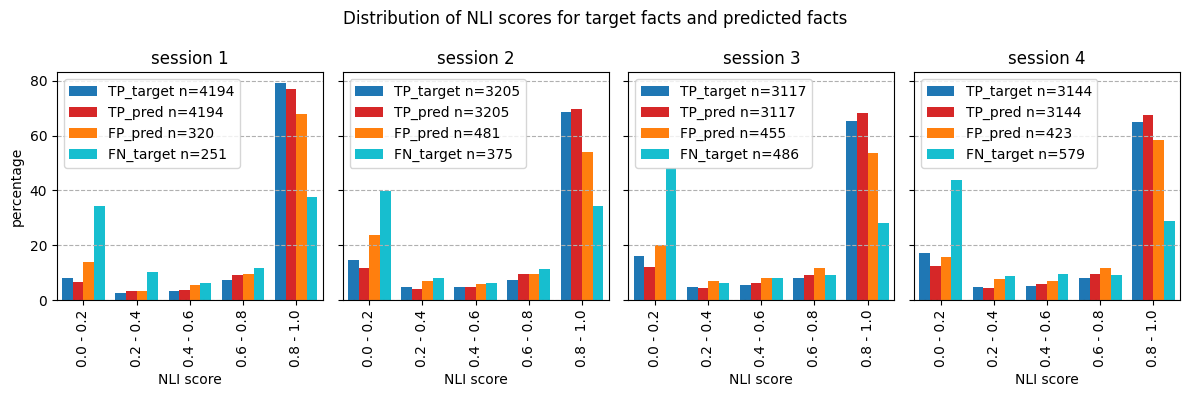

In [41]:
sessions = df['session'].unique()

selection = {}
selection["TP"] = (df['target_fact'] == 1) & (df['pred_fact'] == 1)
selection["TN"] = (df['target_fact'] == 0) & (df['pred_fact'] == 0)
selection["FP"] = (df['target_fact'] == 0) & (df['pred_fact'] == 1)
selection["FN"] = (df['target_fact'] == 1) & (df['pred_fact'] == 0)

fig, axs = plt.subplots(ncols=len(sessions), figsize=(12,4), sharey=True)
colors = {
    "TP_target": "tab:blue",
    "TP_pred": "tab:red",
    "FP_pred": "tab:orange", 
    "FN_target": "tab:cyan",
}

bin_boundaries = [0, 0.2, 0.4, 0.6, 0.8, 1.01]
bins = [(lower, upper) for lower, upper in zip(bin_boundaries[:-1], bin_boundaries[1:])]
x_range = np.arange(len(bins))

for session, ax in zip(sessions, axs):

    for i, s in enumerate(colors.keys()):
        df_subset = df[selection[s[:2]] & (df['session'] == session)]
        nli_col = 'nli' + s[2:]
        num_perbin = np.array([
            df_subset[(df_subset[nli_col] >= lower) & (df_subset[nli_col] < upper)][nli_col].count()
            for lower, upper in bins
        ])
        num_total =  sum(num_perbin)

        ax.bar(x=x_range+0.2+i*0.2, height=num_perbin/num_total*100, color=colors[s], width=0.2, label=f"{s} n={num_total}")

    ax.set_title(f"session {session}")
    ax.legend()
    ax.grid(which='major', axis='y', linestyle='--')
    ax.set_xlim(0, len(bins))
    ax.tick_params(axis='x', labelrotation = 90)
    ax.set_xticks(x_range + 0.5)
    ax.set_xticklabels(f"{lower:.1f} - {upper:.1f}" for lower, upper in bins)
    ax.set_xlabel("NLI score")
    if session == 1:
        # ax.set_yticks(np.array(range(21)))
        # ax.set_yticklabels(np.array(range(21))*2)
        ax.set_ylabel("percentage")

fig.suptitle("Distribution of NLI scores for target facts and predicted facts")
fig.tight_layout()

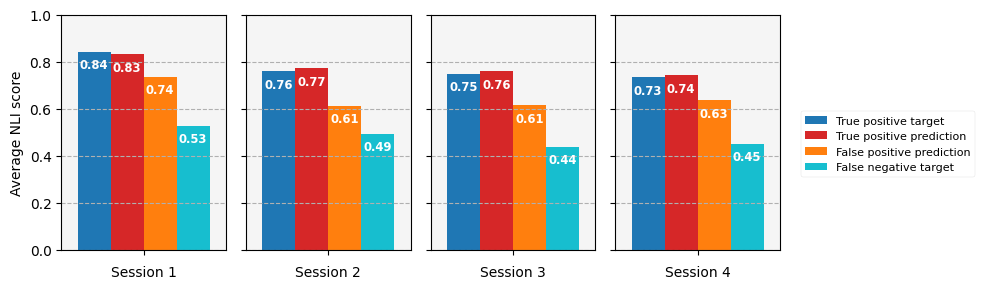

In [203]:
sessions = df['session'].unique()

selection = {}
selection["TP"] = (df['target_fact'] == 1) & (df['pred_fact'] == 1)
selection["TN"] = (df['target_fact'] == 0) & (df['pred_fact'] == 0)
selection["FP"] = (df['target_fact'] == 0) & (df['pred_fact'] == 1)
selection["FN"] = (df['target_fact'] == 1) & (df['pred_fact'] == 0)

fig, axs = plt.subplots(ncols=len(sessions), figsize=(8,3), sharey=True)
colors = {
    "TP_target": "tab:blue",
    "TP_pred": "tab:red",
    "FP_pred": "tab:orange", 
    "FN_target": "tab:cyan",
}
labels = {
    "TP_target": "True positive target",
    "TP_pred": "True positive prediction",
    "FP_pred": "False positive prediction", 
    "FN_target": "False negative target",
}

bin_boundaries = [0, 1.01]
bins = [(lower, upper) for lower, upper in zip(bin_boundaries[:-1], bin_boundaries[1:])]
x_range = np.arange(len(bins))

with plt.style.context('seaborn-v0_8-paper'):
    for session, ax in zip(sessions, axs):

        for i, s in enumerate(colors.keys()):
            df_subset = df[selection[s[:2]] & (df['session'] == session)]
            nli_col = 'nli' + s[2:]
            avg_perbin = np.array([
                df_subset[(df_subset[nli_col] >= lower) & (df_subset[nli_col] < upper)][nli_col].mean()
                for lower, upper in bins
            ])
            std_perbin = np.array([
                df_subset[(df_subset[nli_col] >= lower) & (df_subset[nli_col] < upper)][nli_col].std()
                for lower, upper in bins
            ])
            x_range_bin = x_range+0.2+i*0.2
            ax.bar(x=x_range_bin, height=avg_perbin, 
                #    yerr=std_perbin, 
                color=colors[s], width=0.2, label=f"{labels[s]}")
            ax.text(x_range_bin[0], avg_perbin - 0.07, f"{avg_perbin[0]:.2f}", horizontalalignment='center', fontweight='bold', fontsize='small', c='w')

        ax.set_facecolor('whitesmoke')
        ax.set_xlabel(f"Session {session}")
        ax.grid(which='major', axis='y', linestyle='--')
        ax.set_xlim(0, len(bins))
        ax.set_xticks(x_range + 0.5)
        ax.set_xticklabels("")
        if session == 1:
            ax.set_ylim(0,1)
            ax.set_ylabel("Average NLI score")

    # fig.suptitle("Average NLI scores for target facts and predicted facts, per session")
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    fig.legend(by_label.values(), by_label.keys(), loc='center left', bbox_to_anchor=(1, 0.5))
    fig.tight_layout()

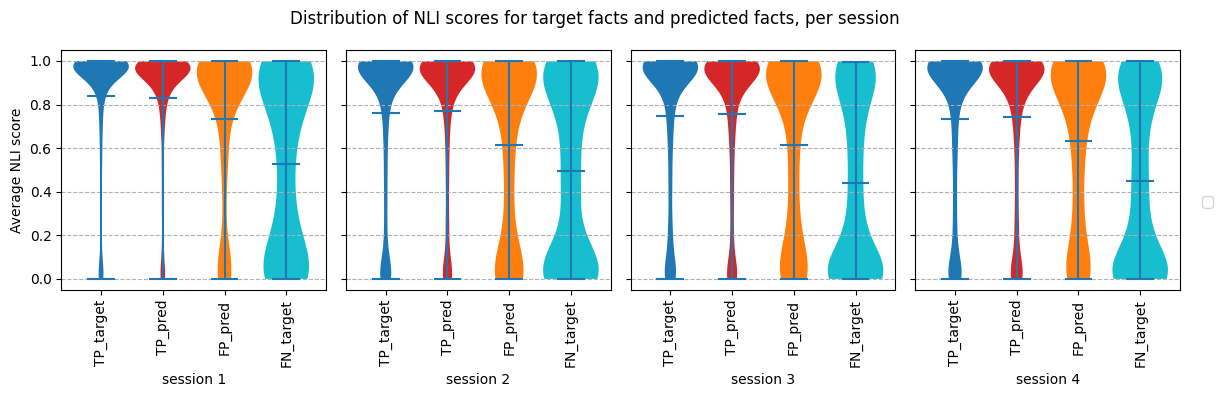

In [204]:
sessions = df['session'].unique()

selection = {}
selection["TP"] = (df['target_fact'] == 1) & (df['pred_fact'] == 1)
selection["TN"] = (df['target_fact'] == 0) & (df['pred_fact'] == 0)
selection["FP"] = (df['target_fact'] == 0) & (df['pred_fact'] == 1)
selection["FN"] = (df['target_fact'] == 1) & (df['pred_fact'] == 0)

fig, axs = plt.subplots(ncols=len(sessions), figsize=(12,4), sharey=True)
colors = {
    "TP_target": "tab:blue",
    "TP_pred": "tab:red",
    "FP_pred": "tab:orange", 
    "FN_target": "tab:cyan",
}

bin_boundaries = [0, 1.01]
bins = [(lower, upper) for lower, upper in zip(bin_boundaries[:-1], bin_boundaries[1:])]
x_range = np.arange(len(bins))

for session, ax in zip(sessions, axs):

    data = [
        df[selection[s[:2]] & (df['session'] == session)]['nli' + s[2:]].values
        for s in colors.keys()
    ]

    plots = ax.violinplot(data, showmeans=True, widths=0.9)

    for pc, color in zip(plots['bodies'], colors.values()):
        pc.set_facecolor(color)
        pc.set_alpha(1)
    ax.set_xlabel(f"session {session}")
    ax.tick_params(axis='x', labelrotation = 90)
    ax.set_xticks([1,2,3,4])
    ax.set_xticklabels(colors.keys())
    ax.grid(which='major', axis='y', linestyle='--')
    if session == 1:
        ax.set_ylim(-0.05, 1.05)
        ax.set_ylabel("Average NLI score")

fig.suptitle("Distribution of NLI scores for target facts and predicted facts, per session")
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
fig.legend(by_label.values(), by_label.keys(), loc='center left', bbox_to_anchor=(1, 0.5))
fig.tight_layout()

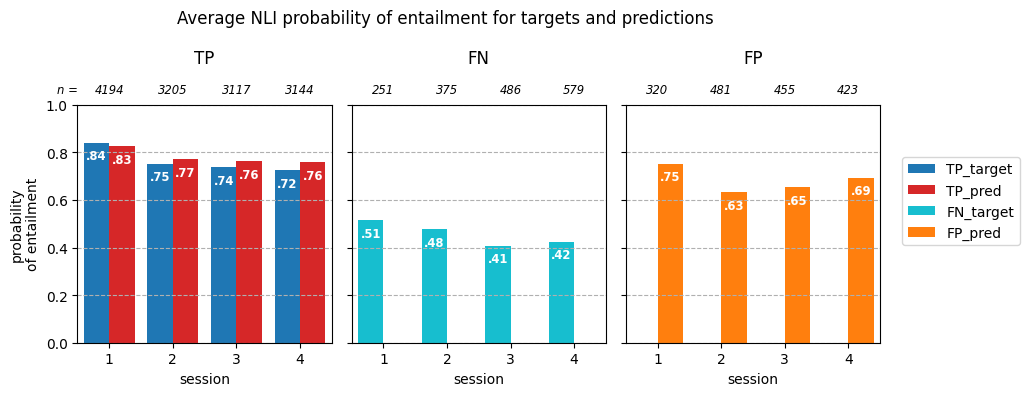

In [49]:
sessions = df['session'].unique()

selection = {}
selection["TP"] = (df['target_fact'] == 1) & (df['pred_fact'] == 1)
selection["TN"] = (df['target_fact'] == 0) & (df['pred_fact'] == 0)
selection["FP"] = (df['target_fact'] == 0) & (df['pred_fact'] == 1)
selection["FN"] = (df['target_fact'] == 1) & (df['pred_fact'] == 0)
colors = {
    "TP_target": "tab:blue",
    "TP_pred": "tab:red",
    "FP_pred": "tab:orange", 
    "FN_target": "tab:cyan",
}
fig, ax = plt.subplots(ncols=3, figsize=(9,4), sharey=True)

for s, a in zip(["TP", "FN", "FP"], ax):

    if s == 'TP' or s == 'FN':
        nli_tgt_mean = df[selection[s]].groupby(['session'])['nli_target'].mean().values
        count = df[selection[s]].groupby(['session'])['nli_target'].count().values
        a.bar(x=sessions - 0.2, height=nli_tgt_mean, width=0.4, color=colors[f"{s}_target"], label=f"{s}_target")
        for session, m in zip(sessions, nli_tgt_mean):
            a.text(session - 0.2, m - 0.07, (f"{m:.2f}")[1:], horizontalalignment='center', fontweight='bold', fontsize='small', c='w')
    if s == 'TP' or s == 'FP':
        nli_pred_mean = df[selection[s]].groupby(['session'])['nli_pred'].mean().values
        count = df[selection[s]].groupby(['session'])['nli_pred'].count().values
        a.bar(x=sessions + 0.2, height=nli_pred_mean, width=0.4, color=colors[f"{s}_pred"], label=f"{s}_pred")
        for session, m in zip(sessions, nli_pred_mean):
            a.text(session + 0.2, m - 0.07, (f"{m:.2f}")[1:], horizontalalignment='center', fontweight='bold', fontsize='small', c='w')

    for session, t in zip(sessions, count):
        a.text(session, 1.05, t, horizontalalignment='center', fontsize='small', fontstyle='italic')
    a.set_title(s, pad=30)
    a.grid(which='major', axis='y', linestyle='--')
    a.set_xlim(0.5, 4.5)
    a.set_xticks(sessions)
    a.set_xlabel("session")
    if s == "TP":
        a.text(0.5, 1.05, "n =", horizontalalignment='right', fontsize='small', fontstyle='italic')
        a.set_ylabel("probability\nof entailment")
        a.set_ylim(0, 1)
    
fig.suptitle("Average NLI probability of entailment for targets and predictions")
# handles, labels = ax[0].get_legend_handles_labels()
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.tight_layout()

### Correlation NLI-score and TERp

1 [0.74742014 0.68419387 0.7154565  0.62629343 0.7055117  0.58388464
 0.57956759 0.60209967 0.58552289 0.54304579] [ 226   57   68   69   67   87  157  232  555 2676]
2 [0.80864429 0.8065358  0.85265985 0.7780471  0.78391603 0.77008992
 0.76692463 0.76929329 0.7276464  0.69092895] [ 298   80   50   78   82   75  116  186  392 1848]
3 [0.86872086 0.77121909 0.86270688 0.84068796 0.8305078  0.79073371
 0.74048917 0.79639852 0.77583204 0.71967736] [ 297   78   70   72   81  113  105  179  363 1759]
4 [0.86437892 0.8477056  0.81045847 0.83080856 0.80974887 0.79203009
 0.85716084 0.73932878 0.76839678 0.71383852] [ 311   85   76   67   86   95  114  184  377 1749]


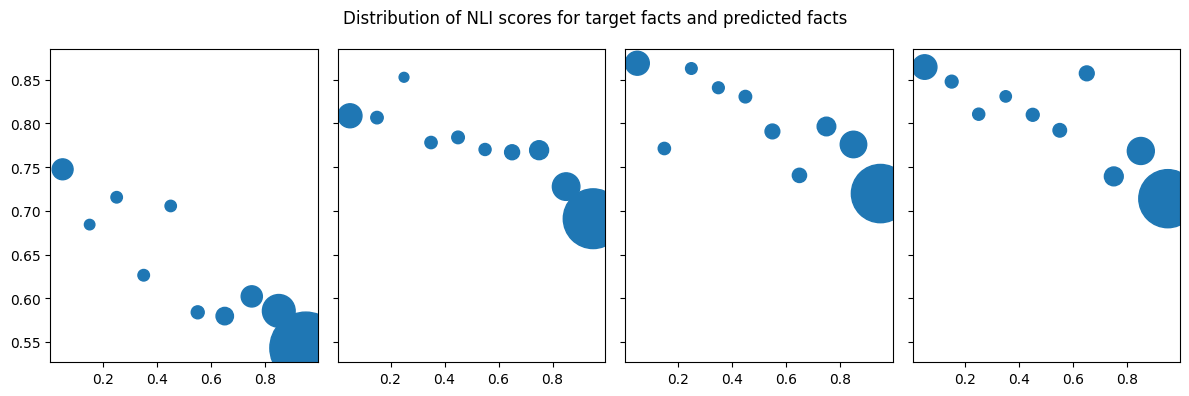

In [42]:
# relation between NLI score and TERp score

sessions = df['session'].unique()

selection = {}
selection["TP"] = (df['target_fact'] == 1) & (df['pred_fact'] == 1)
selection["TN"] = (df['target_fact'] == 0) & (df['pred_fact'] == 0)
selection["FP"] = (df['target_fact'] == 0) & (df['pred_fact'] == 1)
selection["FN"] = (df['target_fact'] == 1) & (df['pred_fact'] == 0)

fig, axs = plt.subplots(ncols=len(sessions), figsize=(12,4), sharey=True)

bin_boundaries = np.linspace(0, 1.0, num=11)
bins = [(lower, upper) for lower, upper in zip(bin_boundaries[:-1], bin_boundaries[1:])]
x_range = np.arange(len(bins))

for session, ax in zip(sessions, axs):

    df_subset = df[selection["TP"] & (df['session'] == session)]
    nli_col = 'nli_pred'
    num_perbin = np.array([
        df_subset[(df_subset[nli_col] >= lower) & (df_subset[nli_col] < upper)][nli_col].count()
        for lower, upper in bins
    ])
    num_total = sum(num_perbin)
    avg_terp = np.array([
        df_subset[(df_subset[nli_col] >= lower) & (df_subset[nli_col] < upper)]['terp'].mean()
        for lower, upper in bins
    ])
    print(session, avg_terp, num_perbin)

    ax.scatter(bin_boundaries[:-1] + 0.05, avg_terp, s=num_perbin)

    # ax.set_title(f"session {session}")
    # ax.legend()
    # ax.grid(which='major', axis='y', linestyle='--')
    # ax.set_xlim(0, len(bins))
    # ax.tick_params(axis='x', labelrotation = 90)
    # ax.set_xticks(x_range + 0.5)
    # ax.set_xticklabels(f"{lower:.1f} - {upper:.1f}" for lower, upper in bins)
    # ax.set_xlabel("NLI score")
    # if session == 1:
    #     # ax.set_yticks(np.array(range(21)))
    #     # ax.set_yticklabels(np.array(range(21))*2)
    #     ax.set_ylabel("percentage")

fig.suptitle("Distribution of NLI scores for target facts and predicted facts")
fig.tight_layout()

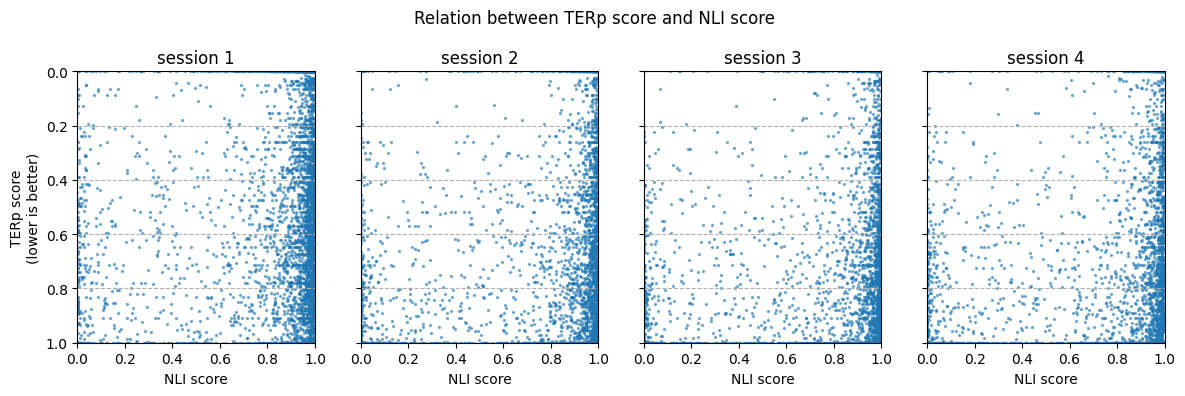

In [205]:
sessions = df['session'].unique()

selection = {}
selection["TP"] = (df['target_fact'] == 1) & (df['pred_fact'] == 1)
selection["TN"] = (df['target_fact'] == 0) & (df['pred_fact'] == 0)
selection["FP"] = (df['target_fact'] == 0) & (df['pred_fact'] == 1)
selection["FN"] = (df['target_fact'] == 1) & (df['pred_fact'] == 0)

fig, axs = plt.subplots(ncols=len(sessions), figsize=(12,4), sharey=True)

for session, ax in zip(sessions, axs):

    df_subset = df[selection["TP"] & (df['session'] == session)]
    terp_count =  df_subset.count()

    ax.scatter(df_subset['nli_pred'], df_subset['terp'], alpha=0.5, s=2)

    ax.set_title(f"session {session}")
    ax.grid(which='major', axis='y', linestyle='--')
    ax.set_xlim(0,1)
    ax.set_xlabel("NLI score")
    if session == 1:
        ax.set_ylim(1,0)
        ax.set_ylabel("TERp score\n(lower is better)")

fig.suptitle("Relation between TERp score and NLI score")
fig.tight_layout()

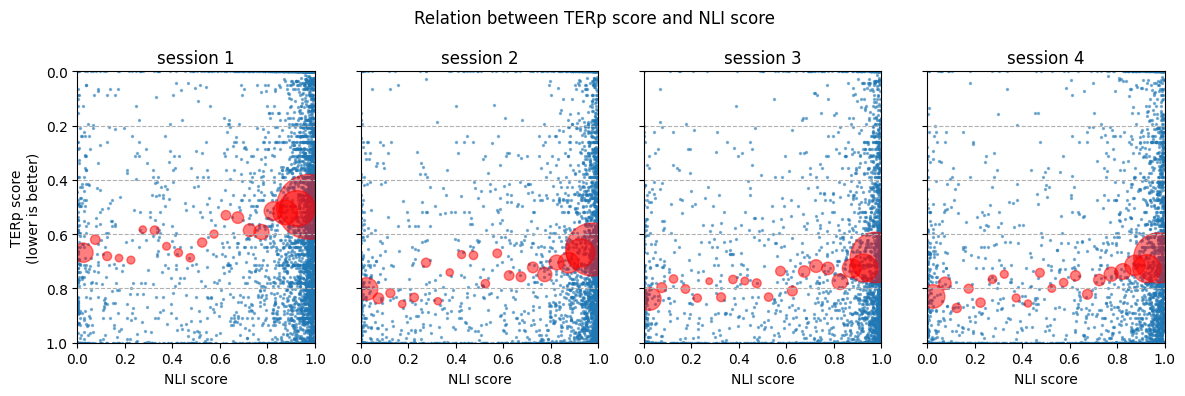

In [206]:
sessions = df['session'].unique()

selection = {}
selection["TP"] = (df['target_fact'] == 1) & (df['pred_fact'] == 1)
selection["TN"] = (df['target_fact'] == 0) & (df['pred_fact'] == 0)
selection["FP"] = (df['target_fact'] == 0) & (df['pred_fact'] == 1)
selection["FN"] = (df['target_fact'] == 1) & (df['pred_fact'] == 0)

num_bins = 20
bin_boundaries = np.linspace(0, 1.0, num=num_bins+1)
bins = [(lower, upper) for lower, upper in zip(bin_boundaries[:-1], bin_boundaries[1:])]

fig, axs = plt.subplots(ncols=len(sessions), figsize=(12,4), sharey=True)

for session, ax in zip(sessions, axs):

    df_subset = df[selection["TP"] & (df['session'] == session)]
    terp_count =  df_subset.count()

    ax.scatter(df_subset['nli_pred'], df_subset['terp'], alpha=0.5, s=2)

    # Calculate average per 'bin' and add it to scatter chart
    nli_col = 'nli_pred'
    num_perbin = np.array([
        df_subset[(df_subset[nli_col] >= lower) & (df_subset[nli_col] < upper)][nli_col].count()
        for lower, upper in bins
    ])
    avg_terp = np.array([
        df_subset[(df_subset[nli_col] >= lower) & (df_subset[nli_col] < upper)]['terp'].mean()
        for lower, upper in bins
    ])
    ax.scatter(bin_boundaries[:-1] + 0.5/num_bins, avg_terp, s=num_perbin, c='r', alpha=0.5)

    ax.set_title(f"session {session}")
    ax.grid(which='major', axis='y', linestyle='--')
    ax.set_xlim(0,1)
    ax.set_xlabel("NLI score")
    if session == 1:
        ax.set_ylim(1,0)
        ax.set_ylabel("TERp score\n(lower is better)")

fig.suptitle("Relation between TERp score and NLI score")
fig.tight_layout()

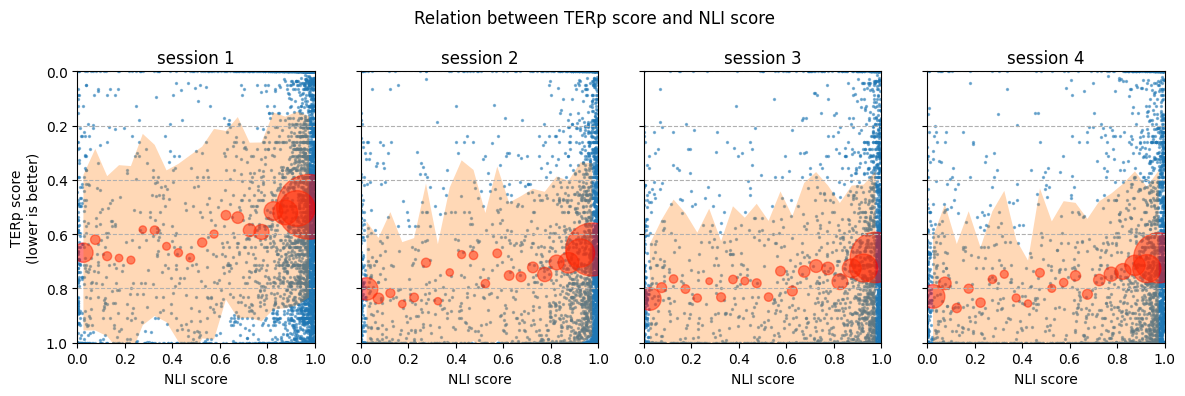

In [207]:
sessions = df['session'].unique()

selection = {}
selection["TP"] = (df['target_fact'] == 1) & (df['pred_fact'] == 1)
selection["TN"] = (df['target_fact'] == 0) & (df['pred_fact'] == 0)
selection["FP"] = (df['target_fact'] == 0) & (df['pred_fact'] == 1)
selection["FN"] = (df['target_fact'] == 1) & (df['pred_fact'] == 0)

num_bins = 20
bin_boundaries = np.linspace(0, 1.0, num=num_bins+1)
bins = [(lower, upper) for lower, upper in zip(bin_boundaries[:-1], bin_boundaries[1:])]

fig, axs = plt.subplots(ncols=len(sessions), figsize=(12,4), sharey=True)

for session, ax in zip(sessions, axs):

    df_subset = df[selection["TP"] & (df['session'] == session)]
    terp_count =  df_subset.count()

    ax.scatter(df_subset['nli_pred'], df_subset['terp'], alpha=0.5, s=2)
    corr = df_subset[['nli_pred', 'terp']].corr().values[0,1]
    # print(corr)
    
    # Calculate average per 'bin' and add it to scatter chart
    terp_data = np.array([
        df_subset[(df_subset[nli_col] >= lower) & (df_subset[nli_col] < upper)]['terp'].agg(['mean', 'std', 'count'])
        for lower, upper in bins
    ])
    ax.scatter(bin_boundaries[:-1] + 0.5/num_bins, terp_data[:, 0], s=terp_data[:, 2], c='r', alpha=0.5)
    ax.fill_between(bin_boundaries[:-1] + 0.5/num_bins, y1=terp_data[:, 0] - terp_data[:, 1], y2=terp_data[:, 0] + terp_data[:, 1], alpha=0.3)

    ax.set_title(f"session {session}")
    ax.grid(which='major', axis='y', linestyle='--')
    ax.set_xlim(0,1)
    ax.set_xlabel("NLI score")
    if session == 1:
        ax.set_ylim(1,0)
        ax.set_ylabel("TERp score\n(lower is better)")

fig.suptitle("Relation between TERp score and NLI score")
fig.tight_layout()

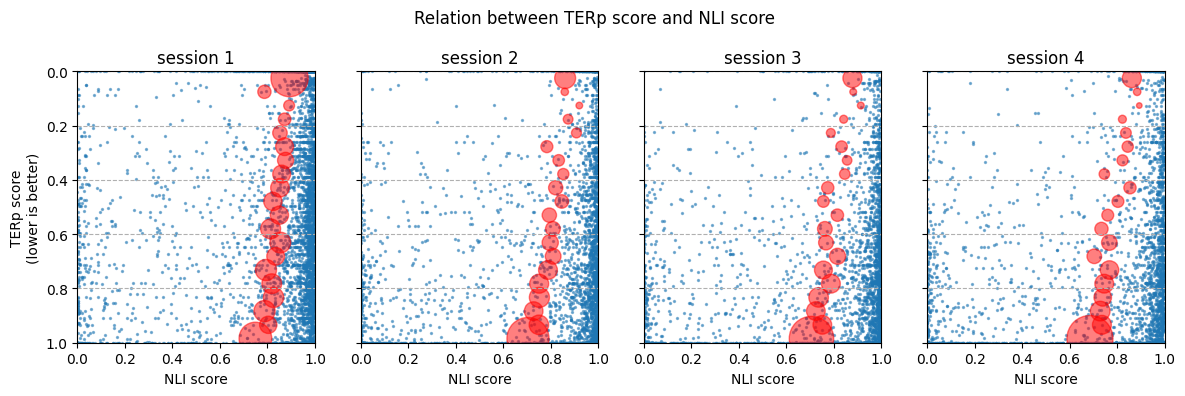

In [208]:
sessions = df['session'].unique()

selection = {}
selection["TP"] = (df['target_fact'] == 1) & (df['pred_fact'] == 1)
selection["TN"] = (df['target_fact'] == 0) & (df['pred_fact'] == 0)
selection["FP"] = (df['target_fact'] == 0) & (df['pred_fact'] == 1)
selection["FN"] = (df['target_fact'] == 1) & (df['pred_fact'] == 0)

num_bins = 20
bin_boundaries = np.linspace(0, 1.01, num=num_bins+1)
bins = [(lower, upper) for lower, upper in zip(bin_boundaries[:-1], bin_boundaries[1:])]

fig, axs = plt.subplots(ncols=len(sessions), figsize=(12,4), sharey=True)

for session, ax in zip(sessions, axs):

    df_subset = df[selection["TP"] & (df['session'] == session)]
    terp_count =  df_subset.count()

    ax.scatter(df_subset['nli_pred'], df_subset['terp'], alpha=0.5, s=2)
    corr = df_subset[['nli_pred', 'terp']].corr().values[0,1]
    # print(corr)
    
    # Calculate average per 'bin' and add it to scatter chart
    nli_data = np.array([
        df_subset[(df_subset['terp'] >= lower) & (df_subset['terp'] < upper)][nli_col].agg(['mean', 'std', 'count'])
        for lower, upper in bins
    ])
    ax.scatter(nli_data[:, 0], bin_boundaries[:-1] + 0.5/num_bins,  s=nli_data[:, 2], c='r', alpha=0.5)
    # ax.fill_between(bin_boundaries[:-1] + 0.5/num_bins, y1=terp_data[:, 0] - terp_data[:, 1], y2=terp_data[:, 0] + terp_data[:, 1], alpha=0.3)

    ax.set_title(f"session {session}")
    ax.grid(which='major', axis='y', linestyle='--')
    ax.set_xlim(0,1)
    ax.set_xlabel("NLI score")
    if session == 1:
        ax.set_ylim(1,0)
        ax.set_ylabel("TERp score\n(lower is better)")

fig.suptitle("Relation between TERp score and NLI score")
fig.tight_layout()

## Evaluation of Summaries

### Load stats and evalresults

In [9]:
# Load the eval_results in dict

eval_results_dir = "/Users/FrankVerhoef/Programming/PEX/output/eval_results/"

# set file filter to select the appropriate statsfiles
file_filter = '20230714_20'  # test with 100 samples from session 3
# file_filter = '20230628_12' # trials with trained2_base_reweighted_bart --> version2
# file_filter = '20230628_2' # trials with trained_base_reweighted_bart --> version1

# retrieve the selected file names and display them --> make sure the '_stats' and the '_evalresults' file have same timestamp
files = sorted([item.path for item in os.scandir(eval_results_dir) if item.path.find(file_filter) > 0])
files

['/Users/FrankVerhoef/Programming/PEX/output/eval_results/trained_nll05_bart_20230714_201356_evalresults.txt',
 '/Users/FrankVerhoef/Programming/PEX/output/eval_results/trained_nll05_bart_20230714_201356_stats.txt']

In [55]:
# Parse the files and collect results in dict or list

stats_list = []
evalresults_dict = {}
config_list = []
trial_names = list(set([
    '_'.join((f.split('/')[-1].split('_')[:-1]))
    for f in files
]))
print(trial_names)
for trial_name in trial_names:
    with open(f"{eval_results_dir}{trial_name}_stats.txt") as f:
        data = f.read().replace('\n', '')
        stats = json.loads(data.split('}{')[0] + '}')
        stats["trial_name"] = trial_name
        stats["date"] = '_'.join(trial_name.split('_')[-2:])
        config = json.loads('{' + data.split('}{')[1])
        config["trial_name"] = trial_name
        stats_list.append(stats)
        config_list.append(config)

    with open(f"{eval_results_dir}{trial_name}_evalresults.txt") as f:
        data = f.read().replace('\n', '')
        evalresults = json.loads(data.split('}{')[0] + '}')
        evalresults = {literal_eval(k): v for k, v in evalresults.items()}
        for k in evalresults.keys():
            evalresults[k]['trial_name'] = trial_name
        evalresults_dict[trial_name] = evalresults
    
print(len(stats_list), len(evalresults_dict), len(config_list))
metrics = ["eval_" + m for m in ['ter', 'bert', 'terp', 'nli_tp', 'nli_pt', 'nli_avg']]
submetrics = ['f1', 'precision', 'recall']
sessions = [3]

['trained_nll05_bart_20230714_201356']
1 1 1


In [56]:
# Convert list with stats and configs to dataframe

summary_stats_df = pd.DataFrame.from_dict(stats_list)
summary_stats_df = summary_stats_df.set_index("trial_name")
summary_config_df = pd.DataFrame(config_list)
summary_config_df = summary_config_df.set_index("trial_name")
summary_stats_df = summary_stats_df.join(summary_config_df, validate="1:1")

In [57]:
summary_stats_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1 entries, trained_nll05_bart_20230714_201356 to trained_nll05_bart_20230714_201356
Data columns (total 72 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   eval_terp               1 non-null      object 
 1   eval_nli_tp             1 non-null      object 
 2   eval_nli_pt             1 non-null      object 
 3   eval_nli_avg            1 non-null      object 
 4   eval_bert               1 non-null      object 
 5   eval_ter                1 non-null      object 
 6   eval_terp_f1            1 non-null      float64
 7   eval_terp_precision     1 non-null      float64
 8   eval_terp_recall        1 non-null      float64
 9   eval_nli_tp_f1          1 non-null      float64
 10  eval_nli_tp_precision   1 non-null      float64
 11  eval_nli_tp_recall      1 non-null      float64
 12  eval_nli_pt_f1          1 non-null      float64
 13  eval_nli_pt_precision   1 non-null    

In [59]:
def get_length(metric_dict, key):
    v = metric_dict[key]
    return len(v)

item_stats_df = pd.concat([
    pd.concat([
        pd.DataFrame.from_dict(summary_stats_df[m].iloc[i]) 
        for i in range(len(summary_stats_df))
    ])
    for m in metrics
], axis=1)
print(pd.MultiIndex.from_tuples(list(itertools.product(metrics, submetrics))))
item_stats_df.columns = pd.MultiIndex.from_tuples(list(itertools.product(metrics, submetrics)))
item_stats_df['session'] = np.array([
    [s] * l 
    for s, l in zip(sessions, summary_stats_df['eval_ter'].apply(lambda x:get_length(x, 'f1s')).values)
]).flatten()
item_stats_df

MultiIndex([(    'eval_ter',        'f1'),
            (    'eval_ter', 'precision'),
            (    'eval_ter',    'recall'),
            (   'eval_bert',        'f1'),
            (   'eval_bert', 'precision'),
            (   'eval_bert',    'recall'),
            (   'eval_terp',        'f1'),
            (   'eval_terp', 'precision'),
            (   'eval_terp',    'recall'),
            ( 'eval_nli_tp',        'f1'),
            ( 'eval_nli_tp', 'precision'),
            ( 'eval_nli_tp',    'recall'),
            ( 'eval_nli_pt',        'f1'),
            ( 'eval_nli_pt', 'precision'),
            ( 'eval_nli_pt',    'recall'),
            ('eval_nli_avg',        'f1'),
            ('eval_nli_avg', 'precision'),
            ('eval_nli_avg',    'recall')],
           )


eval_ter                     eval_bert                     eval_terp  \
          f1 precision    recall        f1 precision    recall        f1   
0   0.600000  1.000000  0.428571  0.727273  1.000000  0.571429  0.444444   
1   0.857143  1.000000  0.750000  1.000000  1.000000  1.000000  0.857143   
2   0.000000  0.000000  0.000000  1.000000  1.000000  1.000000  0.000000   
3   0.666667  1.000000  0.500000  0.400000  0.333333  0.500000  0.333333   
4   0.400000  0.333333  0.500000  0.000000  0.000000  0.000000  0.000000   
..       ...       ...       ...       ...       ...       ...       ...   
95  0.461538  0.600000  0.375000  0.000000  0.000000  0.000000  0.615385   
96  0.615385  0.666667  0.571429  0.000000  0.000000  0.000000  0.307692   
97  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.500000   
98  0.833333  1.000000  0.714286  0.000000  0.000000  0.000000  0.652174   
99  0.363636  0.400000  0.333333  0.000000  0.000000  0.000000  0.428571   

                       eval_nli_tp                     eval_nli_pt            \
   precision    recall          f1 precision    recall          f1 precision   
0   1.000000  0.285714    0.444444  1.000000  0.285714    0.444444  1.000000   
1   1.000000  0.750000    0.571429  0.666667  0.500000    0.285714  0.333333   
2   0.000000  0.000000    0.500000  0.500000  0.500000    0.000000  0.000000   
3   0.333333  0.333333    0.800000  1.000000  0.666667    0.222222  0.333333   
4   0.000000  0.000000    0.400000  0.333333  0.500000    0.000000  0.000000   
..       ...       ...         ...       ...       ...         ...       ...   
95  0.800000  0.500000    0.615385  0.800000  0.500000    0.461538  0.600000   
96  0.333333  0.285714    0.200000  0.333333  0.142857    0.200000  0.333333   
97  0.500000  0.500000    1.000000  1.000000  1.000000    0.000000  0.000000   
98  0.600000  0.714286    0.500000  0.600000  0.428571    0.333333  0.400000   
99  0.600000  0.333333    0.000000  0.000000  0.000000    0.363636  0.400000   

             eval_nli_avg                     session  
      recall           f1 precision    recall          
0   0.285714     0.444444  1.000000  0.285714       3  
1   0.250000     0.285714  0.333333  0.250000       3  
2   0.000000     0.500000  0.500000  0.500000       3  
3   0.166667     0.222222  0.333333  0.166667       3  
4   0.000000     0.000000  0.000000  0.000000       3  
..       ...          ...       ...       ...     ...  
95  0.375000     0.461538  0.600000  0.375000       3  
96  0.142857     0.000000  0.000000  0.000000       3  
97  0.000000     0.500000  0.500000  0.500000       3  
98  0.285714     0.500000  0.600000  0.428571       3  
99  0.333333     0.363636  0.400000  0.333333       3  

[100 rows x 19 columns]

### Heatmaps

In [ ]:
savedir = "../output/"
session = 3
results_dict = list(evalresults_dict.values())[0]
results_dict = {k:results_dict[k] for k in list(results_dict.keys())[:5]}  # select subset of first X dialogues
print("Number of dialog_id's: ", len(results_dict.keys()))
plot_heatmaps(results_dict, session, subset, savedir)


### Overview of all metrics

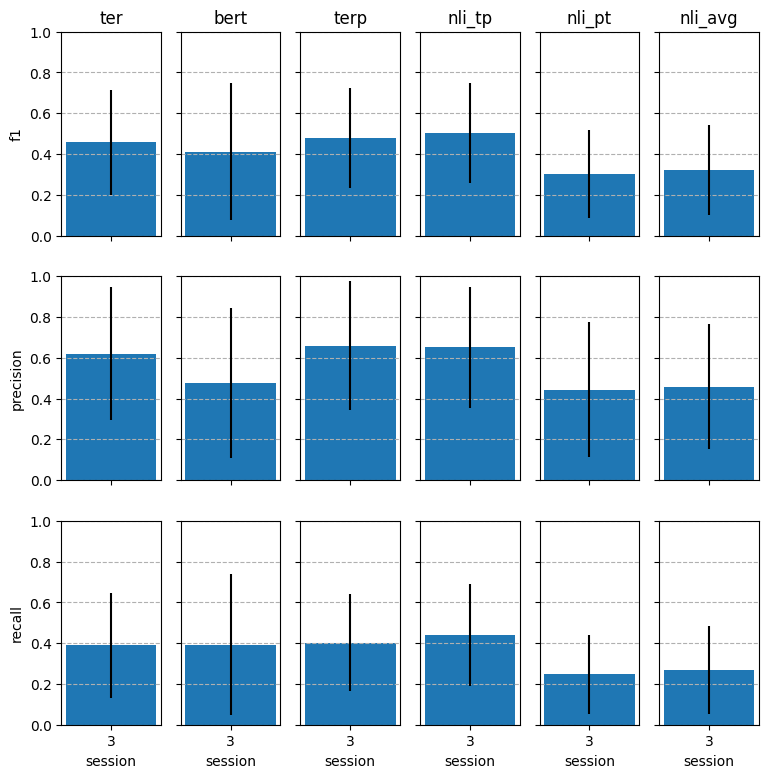

In [67]:
fig, axs = plt.subplots(nrows=len(submetrics), ncols=len(metrics), figsize=(9,9), sharey=True, sharex=True)

for (m2, m1), ax in zip(itertools.product(submetrics, metrics), axs.flatten()):
    data = item_stats_df.groupby('session').agg({(m1, m2): ['mean', 'std']})[(m1, m2)]
    # print(m2, m1, data)
    ax.bar(x=data.index, height=data['mean'], yerr=data['std'])
    ax.set_xticks(data.index)
    ax.grid(which='major', axis='y', linestyle='--')

for i in range(len(metrics)):
    axs[0][i].set_title(metrics[i][5:])
    axs[2][i].set_xlabel('session')
for i in range(len(submetrics)):
    axs[i][0].set_ylim(0,1)
    axs[i][0].set_ylabel(submetrics[i])

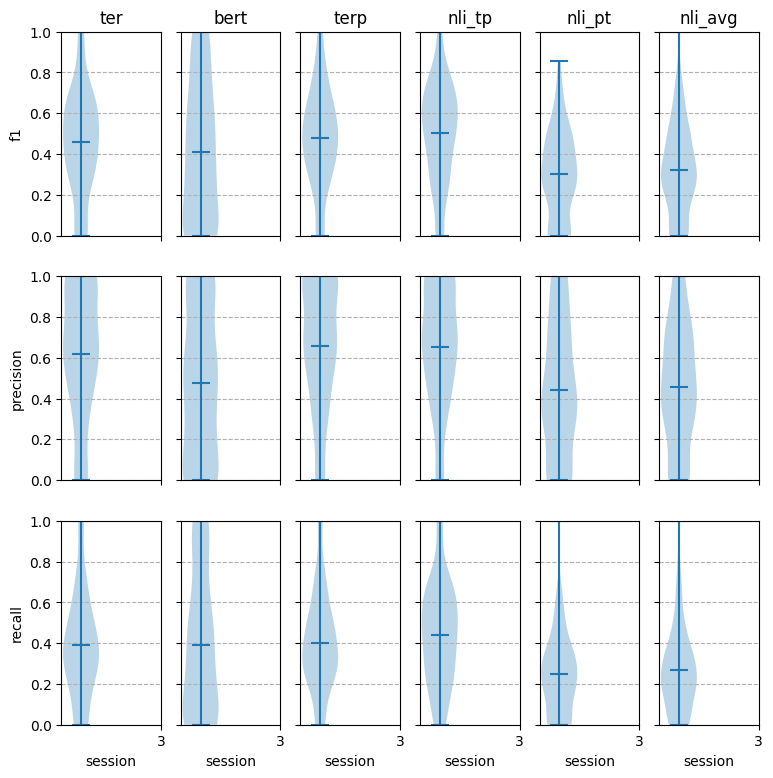

In [71]:
fig, axs = plt.subplots(nrows=len(submetrics), ncols=len(metrics), figsize=(9,9), sharey=True, sharex=True)

for (m2, m1), ax in zip(itertools.product(submetrics, metrics), axs.flatten()):
    data = [item_stats_df[item_stats_df['session'] == s][(m1, m2)] for s in sessions]
    # print(data)
    plots = ax.violinplot(data, showmeans=True, widths=0.9)
    ax.set_xticks(sessions)
    ax.grid(which='major', axis='y', linestyle='--')

for i in range(len(metrics)):
    axs[0][i].set_title(metrics[i][5:])
    axs[2][i].set_xlabel('session')
for i in range(len(submetrics)):
    axs[i][0].set_ylim(0,1)
    axs[i][0].set_ylabel(submetrics[i])


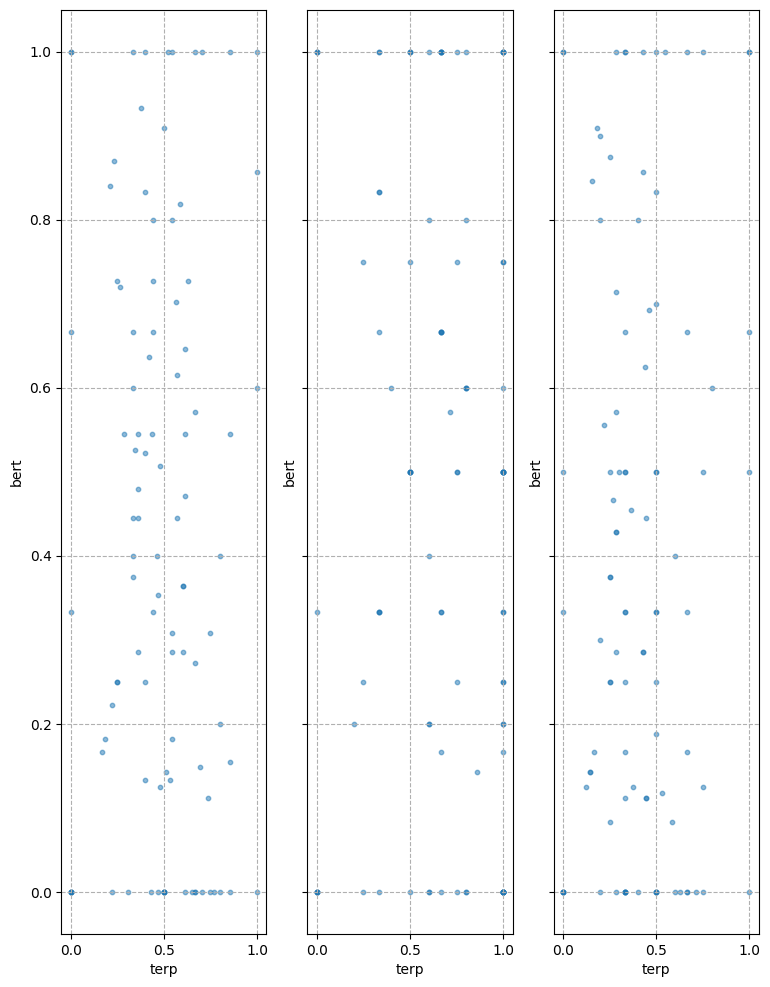

In [74]:
fig, axs = plt.subplots(nrows=len(sessions), ncols=len(submetrics), figsize=(9,12), sharey=True, sharex=True)

for (m2, s), ax in zip(itertools.product(submetrics, sessions), axs.flatten()):
    selection = (item_stats_df['session'] == s)
    x = item_stats_df[selection][('eval_terp', m2)]
    y = item_stats_df[selection][('eval_bert', m2)]
    # print(data)
    ax.scatter(x, y, s=10, alpha=0.5)
    ax.grid(which='major', axis='y', linestyle='--')
    ax.grid(which='major', axis='x', linestyle='--')
    ax.set_xlabel('terp')
    ax.set_ylabel('bert')

# for i in range(len(submetrics)):
#     axs[0][i].set_title(submetrics[i])
#     axs[0][i].set_xlim(0,1)
#     axs[0][i].set_xticks(np.linspace(0, 1, 6))
# for i in range(sessions):
#     axs[i][0].set_ylim(0,1)
#     # axs[i][0].set_ylabel(i)


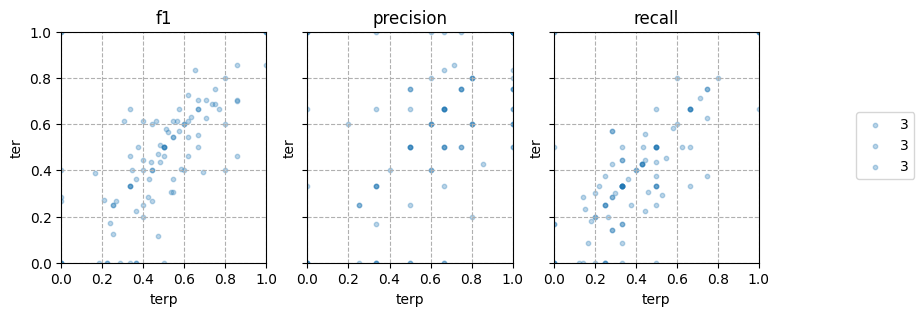

In [75]:
fig, axs = plt.subplots(nrows=1, ncols=len(submetrics), figsize=(9,3), sharey=True, sharex=True)

for m2, ax in zip(submetrics, axs.flatten()):
    for s in sessions:
        selection = (item_stats_df['session'] == s)
        x = item_stats_df[selection][('eval_terp', m2)]
        y = item_stats_df[selection][('eval_ter', m2)]
        # print(data)
        ax.scatter(x, y, s=10, alpha=0.3, label=s)
    ax.set_title(m2)
    # ax.legend()
    ax.grid(which='major', axis='y', linestyle='--')
    ax.grid(which='major', axis='x', linestyle='--')
    ax.set_xlabel('terp')
    ax.set_ylabel('ter')
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.set_xticks(np.linspace(0, 1, 6))

fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [48]:
eval_results_df = pd.concat([
    pd.DataFrame.from_records(list(evalresults_dict[trial_name].values()))
    for trial_name in evalresults_dict.keys()
])
eval_results_df = eval_results_df.join(summary_config_df['session'], on='trial_name')
eval_results_df.head()

,convai_id,pred_sentences,target_sentences,num_combinations,ter,bert,terp,nli,nli_tp,nli_pt,nli_avg,trial_name,session
0,test_688,"[i like chocolate ice cream, i love coconut-pe...","[i own a microwave, i like to eat cookies, i t...",14,"{'scores': [[1.0, 0.75], [0.6000000238418579, ...","{'scores': [[0.42865365743637085, 0.8045634627...","{'scores': [[1.0, 1.0], [0.9339286684989929, 0...",{},"{'scores': [[0.002137151313945651, 0.003759192...","{'scores': [[0.015907226130366325, 0.021105289...","{'scores': [[0.009022188372910023, 0.012432240...",trained_nll05_bart_20230714_201356,3
1,test_101,"[i am an only child, i have students, i want t...","[i'm an only child, i'm a hs teacher, i like m...",12,"{'scores': [[0.5, 1.0, 1.5], [1.25, 1.0, 1.5],...","{'scores': [[0.7549393177032471, 0.77973443269...","{'scores': [[0.4538501501083374, 1.0, 1.0], [1...",{},"{'scores': [[0.9966844916343689, 0.00017462747...","{'scores': [[0.9976905584335327, 0.00016189478...","{'scores': [[0.9971874952316284, 0.00016826113...",trained_nll05_bart_20230714_201356,3
2,test_23,"[i am grateful for farmers, i don't have a co-...",[i do not live close to a co-op but i wish i d...,4,"{'scores': [[0.9230769276618958, 0.76923078298...","{'scores': [[0.7817218899726868, 0.75493931770...","{'scores': [[1.0, 0.9827057123184204], [1.0, 1...",{},"{'scores': [[0.0069190021604299545, 0.99795639...","{'scores': [[0.00028256551013328135, 0.0028129...","{'scores': [[0.0036007838789373636, 0.50038462...",trained_nll05_bart_20230714_201356,3
3,test_782,"[i work as a barista, i want to be a child nur...","[i have previously had a car financed, i work ...",18,"{'scores': [[0.7142857313156128, 0.71428573131...","{'scores': [[0.7589871883392334, 0.74209016561...","{'scores': [[1.0, 1.0, 1.0], [0.77832895517349...",{},"{'scores': [[0.0008728561224415898, 0.00044939...","{'scores': [[0.006747763603925705, 0.005769035...","{'scores': [[0.0038103098049759865, 0.00310921...",trained_nll05_bart_20230714_201356,3
4,test_268,"[i live in the city, i have a horse, i don't s...","[i dont have any horses, i live in a city, las...",6,"{'scores': [[0.6000000238418579, 0.69999998807...","{'scores': [[0.5947594046592712, 0.62494361400...","{'scores': [[0.9198333024978638, 0.95914626121...",{},"{'scores': [[0.9971666932106018, 0.00039957961...","{'scores': [[0.0011092681670561433, 0.00022980...","{'scores': [[0.4991379678249359, 0.00031469465...",trained_nll05_bart_20230714_201356,3


In [76]:
def get_value(metric_dict, key):
    v = metric_dict[key]
    return v
scores_df = pd.concat([
    pd.concat([
        eval_results_df[m].apply(lambda x: get_value(x, key))
        for key in submetrics
    ], axis=1)
    for m in ['ter', 'bert', 'terp']
], axis=1)
scores_df.columns = pd.MultiIndex.from_tuples([(m1, m2) for m1, m2 in itertools.product(['ter', 'bert', 'terp'], submetrics)])
eval_results_df = pd.concat([
    eval_results_df,
    scores_df
], axis=1)
eval_results_df.head()

,convai_id,pred_sentences,target_sentences,num_combinations,ter,bert,terp,nli,nli_tp,nli_pt,...,session,"(ter, f1)","(ter, precision)","(ter, recall)","(bert, f1)","(bert, precision)","(bert, recall)","(terp, f1)","(terp, precision)","(terp, recall)"
0,test_688,"[i like chocolate ice cream, i love coconut-pe...","[i own a microwave, i like to eat cookies, i t...",14,"{'scores': [[1.0, 0.75], [0.6000000238418579, ...","{'scores': [[0.42865365743637085, 0.8045634627...","{'scores': [[1.0, 1.0], [0.9339286684989929, 0...",{},"{'scores': [[0.002137151313945651, 0.003759192...","{'scores': [[0.015907226130366325, 0.021105289...",...,3,0.600000,1.000000,0.428571,0.727273,1.000000,0.571429,0.444444,1.000000,0.285714
1,test_101,"[i am an only child, i have students, i want t...","[i'm an only child, i'm a hs teacher, i like m...",12,"{'scores': [[0.5, 1.0, 1.5], [1.25, 1.0, 1.5],...","{'scores': [[0.7549393177032471, 0.77973443269...","{'scores': [[0.4538501501083374, 1.0, 1.0], [1...",{},"{'scores': [[0.9966844916343689, 0.00017462747...","{'scores': [[0.9976905584335327, 0.00016189478...",...,3,0.857143,1.000000,0.750000,1.000000,1.000000,1.000000,0.857143,1.000000,0.750000
2,test_23,"[i am grateful for farmers, i don't have a co-...",[i do not live close to a co-op but i wish i d...,4,"{'scores': [[0.9230769276618958, 0.76923078298...","{'scores': [[0.7817218899726868, 0.75493931770...","{'scores': [[1.0, 0.9827057123184204], [1.0, 1...",{},"{'scores': [[0.0069190021604299545, 0.99795639...","{'scores': [[0.00028256551013328135, 0.0028129...",...,3,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
3,test_782,"[i work as a barista, i want to be a child nur...","[i have previously had a car financed, i work ...",18,"{'scores': [[0.7142857313156128, 0.71428573131...","{'scores': [[0.7589871883392334, 0.74209016561...","{'scores': [[1.0, 1.0, 1.0], [0.77832895517349...",{},"{'scores': [[0.0008728561224415898, 0.00044939...","{'scores': [[0.006747763603925705, 0.005769035...",...,3,0.666667,1.000000,0.500000,0.400000,0.333333,0.500000,0.333333,0.333333,0.333333
4,test_268,"[i live in the city, i have a horse, i don't s...","[i dont have any horses, i live in a city, las...",6,"{'scores': [[0.6000000238418579, 0.69999998807...","{'scores': [[0.5947594046592712, 0.62494361400...","{'scores': [[0.9198333024978638, 0.95914626121...",{},"{'scores': [[0.9971666932106018, 0.00039957961...","{'scores': [[0.0011092681670561433, 0.00022980...",...,3,0.400000,0.333333,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


### Length

(0.0, 100.0)


(0.0, 100.0)

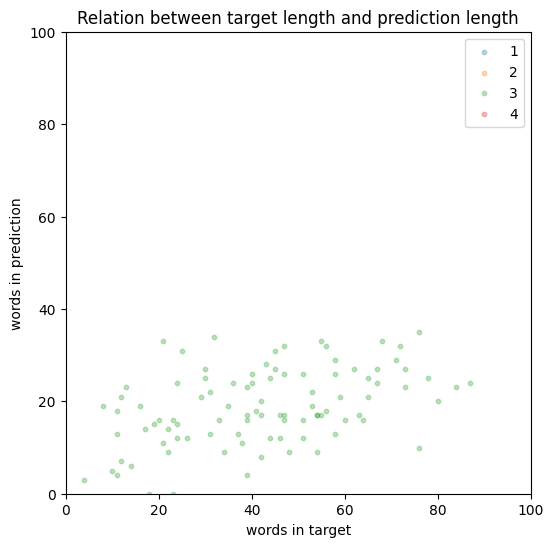

In [77]:
def get_length(sentence_list):
    l = sum([len(s.split()) for s in sentence_list])
    return l

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,6))

for s in [1, 2, 3, 4]:
    selection = (eval_results_df['session'] == s)
    x = eval_results_df[selection]['target_sentences'].apply(lambda x: get_length(x))
    y = eval_results_df[selection]['pred_sentences'].apply(lambda x: get_length(x))
    ax.scatter(x, y, s=10, alpha=0.3, label=s)
ax.set_title("Relation between target length and prediction length")
ax.legend()
# ax.grid(which='major', axis='y', linestyle='--')
# ax.grid(which='major', axis='x', linestyle='--')
ax.set_xlabel('words in target')
ax.set_ylabel('words in prediction')
ax.set_xlim(0, 100)
print(ax.get_xlim())
ax.set_ylim(ax.get_xlim())


(0.0, 80.0)

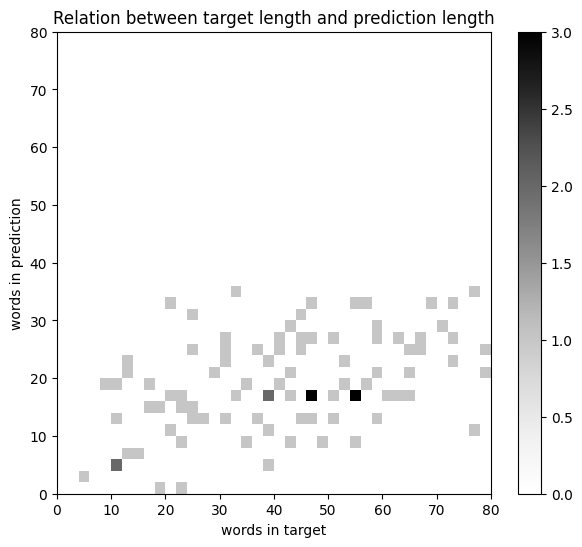

In [78]:
def get_length(sentence_list):
    l = sum([len(s.split()) for s in sentence_list])
    return l

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,6))
bin_edges = np.linspace(0,80, 41)

x = eval_results_df['target_sentences'].apply(lambda x: get_length(x))
y = eval_results_df['pred_sentences'].apply(lambda x: get_length(x))
ax_hist = ax.hist2d(x, y, bins=(bin_edges, bin_edges), cmap='Greys')
fig.colorbar(ax_hist[3])
ax.set_xticks(np.linspace(0,100,11))
ax.set_xlim(0, 80)
ax.set_ylim(ax.get_xlim())
ax.set_title("Relation between target length and prediction length")
# ax.grid(which='major', axis='y', linestyle='--')
# ax.grid(which='major', axis='x', linestyle='--')
ax.set_xlabel('words in target')
ax.set_ylabel('words in prediction')
ax.set_xlim(0, 80)
ax.set_ylim(ax.get_xlim())


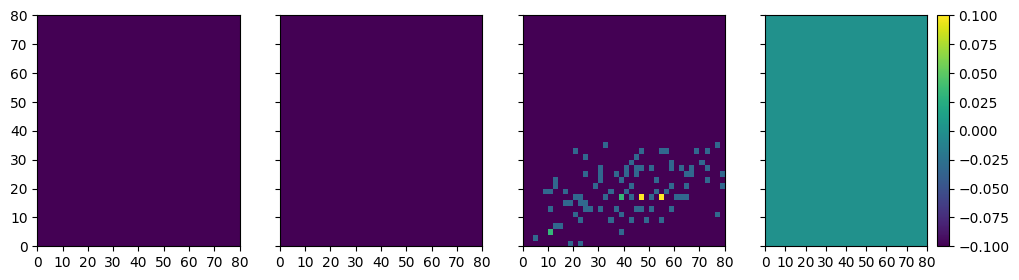

In [79]:
def get_length(sentence_list):
    l = sum([len(s.split()) for s in sentence_list])
    return l

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(12,3), sharey=True)
bin_edges = np.linspace(0,80, 41)
for s, ax in zip([1, 2, 3, 4], axs):
    selection = (eval_results_df['session'] == s)
    x = eval_results_df[selection]['target_sentences'].apply(lambda x: get_length(x))
    y = eval_results_df[selection]['pred_sentences'].apply(lambda x: get_length(x))
    h = ax.hist2d(x, y, bins=(bin_edges, bin_edges))
    ax.set_xticks(np.linspace(0,100,11))
    ax.set_xlim(0, 80)
    ax.set_ylim(ax.get_xlim())
# ax.set_title("Relation between target length and prediction length")
# ax.legend()
# # ax.grid(which='major', axis='y', linestyle='--')
# # ax.grid(which='major', axis='x', linestyle='--')
# ax.set_xlabel('words in target')
# ax.set_ylabel('words in prediction')

fig.colorbar(h[3], ax=ax)

(0.0, 17.8)


(0.0, 17.8)

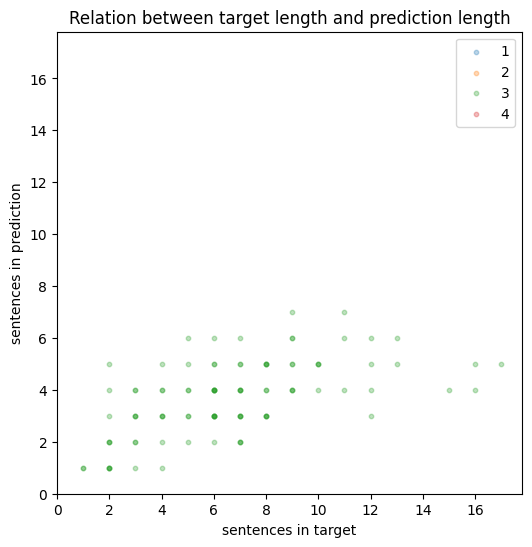

In [80]:
def get_length(sentence_list):
    l = len(sentence_list)
    return l

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,6))

for s in [1, 2, 3, 4]:
    selection = (eval_results_df['session'] == s)
    x = eval_results_df[selection]['target_sentences'].apply(lambda x: get_length(x))
    y = eval_results_df[selection]['pred_sentences'].apply(lambda x: get_length(x))
    ax.scatter(x, y, s=10, alpha=0.3, label=s)
ax.set_title("Relation between target length and prediction length")
ax.legend()
# ax.grid(which='major', axis='y', linestyle='--')
# ax.grid(which='major', axis='x', linestyle='--')
ax.set_xlabel('sentences in target')
ax.set_ylabel('sentences in prediction')
ax.set_xlim(0)
print(ax.get_xlim())
ax.set_ylim(ax.get_xlim())


In [81]:
best_summaries = eval_results_df.sort_values(by=('terp', 'f1'), ascending=False).head(10)
m1m2 = [(m1, m2) for m1, m2 in itertools.product(['ter', 'bert', 'terp'], submetrics)]

for i in range(len(best_summaries)):
    print("Target:")
    print('\n'.join(best_summaries.iloc[i]['target_sentences']))
    print("Prediction")
    print('\n'.join(best_summaries.iloc[i]['pred_sentences']))
    print(best_summaries.iloc[i][m1m2])

Target:
i will leave college soon
i don't have much working experience
Prediction
i am leaving for college soon
i don't have a lot of experience
(ter, f1)            1.0
(ter, precision)     1.0
(ter, recall)        1.0
(bert, f1)           1.0
(bert, precision)    1.0
(bert, recall)       1.0
(terp, f1)           1.0
(terp, precision)    1.0
(terp, recall)       1.0
Name: 15, dtype: object
Target:
i dont have kids
Prediction
i have kids
(ter, f1)            1.0
(ter, precision)     1.0
(ter, recall)        1.0
(bert, f1)           0.0
(bert, precision)    0.0
(bert, recall)       0.0
(terp, f1)           1.0
(terp, precision)    1.0
(terp, recall)       1.0
Name: 21, dtype: object
Target:
i find aquariums relaxing
i used to live in england
i have a dog named hank
Prediction
i like aquariums
i live in england
i have a cat named hank
i have a dog named hank
(ter, f1)                 1.0
(ter, precision)          1.0
(ter, recall)             1.0
(bert, f1)           0.857143
(bert, prec

## Take sample from dataset for analysis

In [19]:
max_inputwords = df['inputwords'].max()
bin_boundaries = [0, 10, 20, 30, 40, 50, 60, 80, 100, max_inputwords]
bins = [(lower + 1, upper) for lower, upper in zip(bin_boundaries[:-1], bin_boundaries[1:])]

selection = {}
selection["TP"] = (df['target_fact'] == 1) & (df['pred_fact'] == 1)
selection["TN"] = (df['target_fact'] == 0) & (df['pred_fact'] == 0)
selection["FP"] = (df['target_fact'] == 0) & (df['pred_fact'] == 1)
selection["FN"] = (df['target_fact'] == 1) & (df['pred_fact'] == 0)

samples = []
for s in selection.keys():
    for lower, upper in bins:
        subset = (selection[s] & (df['inputwords'] >= lower) & (df['inputwords'] <= upper))
        samples.append(df[subset].sample(n=min(10, len(df[subset])), axis=0, replace=False, ignore_index=False).index)

sampled = pd.MultiIndex.from_tuples([id for indexlist in samples for id in indexlist])
sampled

MultiIndex([(1, 275, 12),
            (1, 473,  0),
            (1, 330,  1),
            (1, 311,  6),
            (1, 424,  0),
            (1, 455,  9),
            (1,  19,  0),
            (1, 419, 11),
            (1, 356,  8),
            (1,  86,  0),
            ...
            (3,   3,  9),
            (2, 308,  8),
            (4, 104, 10),
            (4, 429,  6),
            (4, 448,  9),
            (2, 155,  7),
            (4, 463,  5),
            (2, 425,  3),
            (2, 360,  6),
            (3, 254,  6)],
           length=344)

In [20]:
output_dir = "/Users/FrankVerhoef/Programming/PEX/output/"
filename = "sample_newnli.csv"

df.loc[sampled].to_csv(output_dir + filename, sep='\t') 

In [17]:
# Load the saved csv file (with additional columns)
df_index = pd.read_csv(output_dir + "sample_index.csv", sep=';')

# Extract the index
sampled_index = pd.MultiIndex.from_arrays(df_index[['i0', 'i1', 'i2']].values.T)

In [34]:
# Save specified columns
df.loc[sampled_index][['nli_pred', 'nli_target']].to_csv(output_dir + 'new_nli.csv', sep='\t') 

In [7]:
df.loc[(4,258,4)]['history']

"I'm beginning to enjoy the great outdoors much more than I did when I was younger; I do like city breaks but every now and then it's great to be out in the fresh air with stunning views. The Big Sur is meant to be a beautiful place, I hope you are able to go. I've never actually been to California before!<sep>I really hope so too - I'd book it right away if I had the money! It's a long story but I've had trouble finding work lately. I'm okay for money but I'm saving up for my dream car so I have to balance that with potential trips! You'd love California, maybe we can go there together sometime if you can get the time off work!"